# Apartment-Liquidity-Pricing

Em uma proptech, existe uma squad responsável por definir quais apartamentos a proptech deve listar na sua plataforma ou apostar na compra, de forma a permitir o crescimento de vendas em ritmo exponencial, a boa utilização dos recursos financeiros e unit economics saudáveis. As políticas criadas por esse squad influenciam diretamente a liquidez e risco do portfolio da empresa, tanto do ponto de vista financeiro (perdas para a proptech) quanto risco de comprometer a experiência do usuário (preços mal calibrados). As metas de portfolio definidas neste squad se desdobram na empresa, então é crítico que os modelos que suportam essas definições sejam assertivos, e que a estratégia de portfolio adotada siga uma lógica que faça sentido.

Em anexo, existem dois arquivos. O primeiro arquivo, simulated_listings.csv, contém todos os apartamentos que foram anunciados e transacionados em uma São Paulo fictícia durante um semestre. Nele, temos variáveis descrevendo o tamanho do apartamento (rooms, garages, useful_area), sua localização (latitude, longitude), e seu estado de conservação (interior_quality). Além disso, temos o valor do apartamento (value), o total de dias em que ele está no mercado (time_on_market) e se ele foi vendido ou não (sold, 1 = vendido).

O desafio é criar um algoritmo de alocação de portfolio para decidir, entre os apartamentos disponíveis na target_apartments.csv, quais a proptech deve comprar, reformar e vender, no seguinte cenário:

* Pagamos exatamente o valor pedido pelo proprietário (coluna value na base target_apartments.csv).
* A reforma traz o apartamento para o melhor estado de conservação possível (interior_quality=3).
* O capital disponível para compra dos apartamentos é de R$ 150 milhões.

Quais apartamentos você compraria (dentre os disponíveis na target_apartments.csv), e por
qual preço você listaria esses apartamentos depois da reforma, de modo a maximizar a nossa
receita esperada (valor de venda - valor de compra) por unidade de tempo (R$/dia)?

**Sumário**

* 1. [Entendimento do Problema de Negócio](#entendimento)
* 2. [Imports](#imports)
    * 2.1. [Funções Auxiliares](#funcoes)
    * 2.2. [Carregamento de dados](#carregamento)
* 3. [Descrição dos Dados](#descricao_dos_dados)
    * 3.1. [Dimensão dos Dados](#dimensao_dos_dados)
    * 3.2. [Tipo dos Dados](#tipo_dos_dados)
    * 3.3. [Checagem de Dados Faltantes](#check_na)
    * 3.4. <s>[Preenchimento de Dados Faltantes](#preenchimento)<s/>
    * 3.5. [Estatística Descritiva](#estatistica_descritiva)
* 4. [Feature Engineering](#feature_engineering)
    * 4.1. [Criação de Hipóteses](#hipoteses)
    * 4.2. [Novas Features](#novas_features)
* 5. [Análise Exploratória de Dados](#analise_exploratoria)
    * 5.1. [Análise Univariada](#analise_univariada)
        * 5.1.1. [Variáveis Dependentes](#variaveis_dependentes)
        * 5.1.2. [Variáveis Independentes](#variaveis_independentes)
    * 5.2. [Análise Bivariada](#analise_bivariada)
    * 5.3. [Análise Multivariada](#analise_multivariada)
* 6. [Análise de Sobrevivência](#analise_de_sobrevivencia)
    * 6.1. [Teoria - Análise de Sobrevivência](#teoria_sobrevivencia)
    * 6.2. [Função de Sobrevivência - Kaplan-Meier](#kaplan-meier)
        * 6.2.1. [Gráfico de Kaplan-Meier](#grafico_kaplan)
    * 6.3. [Kaplan-Meier por estado de conservação](#kaplan_conservacao)
        * 6.3.1. [Gráfico Kaplan-Meier por estado de conservação](#grafico_kaplan_conservacao)
    * 6.4. [Kaplan-Meier por estado de conservação e por preço](#kaplan_conservacao_preco)
        * 6.4.1. [Gráfico Kaplan-Meier por estado de conservação e por preço](#grafico_kaplan_conservacao_preco)
    * 6.5. [Teste Log-Rank](#log_rank)
        * 6.5.1. [Teste Log-Rank conservação](#log_rank_conservacao)
        * 6.5.2. [Teste Log-Rank preço](#log_rank_preco)
* 7. [Preparação dos dados](#preparacao)
    * 7.1. [Filtragem de Colunas](#filtragem_colunas)
    * 7.2. [Encoding](#rescale_encoding)
    * 7.3. [Separação Treino-Validação](#treino_validacao)
* 8. [Modelagem de Machine Learning](#machile_learning)
    * 8.1. [Teoria XGBoost Survival Embeddings](#xgboost)
    * 8.2. [Parâmetros](#parametros)
    * 8.3. [XGBoost + Regressão Logística - Cross Validation](#xgb_logistic_cv)
    * 8.4. [XGBoost + Árvore Única - Cross Validation](#xgb_arvore_cv)
    * 8.5. [XGBoost + Floresta - Cross Validation](#xgb_floresta_cv)
* 9. [Tunning de Hiperparâmetros](#tunning)
    * 9.1. [Modelo Final e Export](#modelo_final)
* 10. [Análise Prescritiva](#prescritiva_negocio)
    * 10.1. [Comparação curvas de sobrevivência](#comparacao_sobrevivencia)
    * 10.2. [Influência do preço na liquidez](#influencia_preco_liquidez)
    * 10.3. [Influência do estado de conservação](#influencia_conservacao)
        * 10.3.1. [Reformando apartamentos em estado de conservação 1 e 2](#reforma_1_2)
        * 10.3.2. [Liquidez entre apartamentos reformados e já em estado de conservação 3](#reformado_3)
* 11. [Seleção de apartamentos e Performance de Negócio](#selecao_apartamentos)
    * 11.1. [Pré-processamento da base de apartamentos](#processmento_target)
    * 11.2. [Previsão do Modelo para combinações de cenários](#previsao_combinacao)

# 1. Entendimento do Problema de Negócio<a id='entendimento'></a>

* **Como é o contexto do problema?**

    * A proptech deseja investir na compra de mais apartamentos, reformá-los e vendê-los, para continuar o crescimento exponencial da empresa.
    
* **Qual é o objetivo?**
    
    * A proptech deseja descobrir quais são os melhores apartamentos para comprar e revender, sendo a liquidez e o preço de vendas algumas das principais variáveis a serem avaliadas. O capital disponível para a compra dos apartamentos é de R$ 150 milhões.
    
* **Por que é necessário?**

    * O time deseja maximizar o lucro por unidade de tempo com a revenda de apartamentos. Assim, é necessário definir preços de revenda e avaliar como esses preços impactam na liquidez do imóvel.
    
* **Como será a solução?**
    
    * Análise prescritiva, modificando variáveis, como preço e tempo até venda, para maximizar o lucro por unidade de tempo.
    * Uma tabela final com sugestões de apartamentos a serem comprados e reformados será fornecida via API, assim como o preço que tais apartamentos deverão ser vendidos.

# 2. Imports<a id='imports'></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import math
import re

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test, multivariate_logrank_test

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

from IPython.core.display import HTML
from IPython.display import display, Markdown, Latex

import warnings

## 2.1. Funções Auxiliares<a id='funcoes'></a>

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 9]
    plt.rcParams['xtick.labelsize'] = 25
    plt.rcParams['ytick.labelsize'] = 25
    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['axes.labelsize'] = 25
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()
    sns.color_palette()
    
    warnings.filterwarnings('ignore')
    
    pd.options.display.float_format = "{:,.2f}".format
    
def describe_df(df):
    #Central Tendency - Mean, Median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    #Dispersion - Std, Min, Max, Range, Skew, Kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
    return metrics

def plot_hypothesis(df, x, y, hue, categorical = False, titles = None, corr = True):
    
    if categorical:
        # box plot sales per school_holiday
        if corr:
            fig, ax = plt.subplots(3,1);
        else:
            fig, ax = plt.subplots(2,1);
        sns.boxplot(x = x, y = y, data = df, hue = hue, palette = 'deep', ax = ax.ravel()[0]);
        if titles:
            ax.ravel()[0].set_title(titles[0]);
        
        # bar plot sales per school_holiday, month
        aux2 = df[[hue, x, y]].groupby([hue, x]).mean().reset_index()
        sns.barplot(x = x, y = y, hue = hue, data = aux2, ax = ax.ravel()[1]);
        if titles:
            ax.ravel()[1].set_title(titles[1]);
            
        # correlation heatmap
        if corr:
            sns.heatmap(df[[x, y]].corr(method = 'pearson'), annot = True, ax = ax.ravel()[2]);
            if titles:
                ax.ravel()[2].set_title(titles[2]);
            
        plt.tight_layout();
    else:
        # scatter plot sales x competition distance
        if corr:
            fig, ax = plt.subplots(1,2);
        else:
            fig, ax = plt.subplots(1,1);
        sns.scatterplot(x = x, y = y, data = df, hue = hue, palette = 'deep', ax = ax.ravel()[0]);
        if titles:
            ax.ravel()[0].set_title(titles[0]);
        
        # correlation heatmap
        if corr:
            sns.heatmap(df[[x, y]].corr(method = 'pearson'), annot = True, ax = ax.ravel()[1]);
            if titles:
                ax.ravel()[1].set_title(titles[1]);
        plt.tight_layout();

def plot_ci(mean, upper_ci, lower_ci, title='Probabilidade de Venda', ax = None, vline = None, hline = None, label = "Probabilidade de Venda"):
    
    # plotting mean and confidence intervals 
    mean = mean.mean()
    upper_ci = upper_ci.mean()
    lower_ci = lower_ci.mean()
    
    if ax:
        ax.plot(mean.index,mean, label = label);
        ax.fill_between(mean.index, lower_ci, upper_ci, alpha=0.2);
        if vline:
            ax.axvline(x=vline, linestyle = '--', color = 'r', label = 'Tempo médio no mercado');
        if hline is not None:
            ax.axhline(y=hline.mean(), linestyle = ':', color = 'r', label = 'Probabilidade média de venda');
        ax.set_title(title);
        ax.set_xlabel('Tempo [dias]');
        ax.set_ylabel('Probabilidade');
        ax.legend();
    else:
        plt.plot(mean.index,mean, label = label);
        plt.fill_between(mean.index, lower_ci, upper_ci, alpha=0.2);
        if vline:
            plt.axvline(x=vline, linestyle = '--', color = 'r', label = 'Tempo médio no mercado')
        if hline is not None:
            plt.axhline(y=hline.mean(), linestyle = ':', color = 'r', label = 'Probabilidade média de venda')
        plt.title(title);
        plt.xlabel('Tempo [dias]');
        plt.ylabel('Probabilidade');
        plt.legend();
    plt.tight_layout();
    
def show_mean_risk(*means, names = [], columns = ['Descrição', 'Probabilidade Média para toda Janela']):
    means_list = []
    names_list = []
    for mean, name in zip(means, names):
        mean_probability = (1 - mean).mean().mean()
        means_list.append(round(mean_probability, 3))
        names_list.append(name)
        
    return pd.DataFrame(np.array([names_list, means_list]).T, columns = columns)

def predict_scenario(apartments, model, multiply_values, renovate = False):
    # verificando se argumentos fornecidos são listas
    if not isinstance(multiply_values, list):
        multiply_values = [multiply_values]
    
    for multiply_value in multiply_values:
        # ----------- aplicando cenário -------------- #
        multiply_name = str(int(round((multiply_value - 1) * 100))) + '%' # nome a ser exibido na coluna para identificação
        apartments_copy = apartments[['useful_area', 'value', 'interior_quality', 'rooms_garages',
                                       'lat_long_bins_01', 'lat_long_bins_02', 'lat_long_bins_10',
                                       'lat_long_bins_11', 'lat_long_bins_12', 'lat_long_bins_20',
                                       'lat_long_bins_21', 'lat_long_bins_22']].copy() # seleção apenas de colunas pertinentes para o modelo
        # aumento de preço
        apartments_copy['value'] = apartments_copy['value'] * multiply_value # alterando valor no dataframe a ter predito
        apartments['value_' + multiply_name] = apartments['value'] * multiply_value # trazendo novo valor de venda para o dataframe original

        # reforma
        if renovate:
            apartments_copy['interior_quality'] = 3
            column_name = f'mais_{multiply_name}_com_reforma'
            print(f"{multiply_name} com reforma")
        else:
            column_name = f'mais_{multiply_name}_sem_reforma'
            print(f"{multiply_name} sem reforma")

        # -------- prevendo probabilidades de venda ----------- #
        predict =  1 - model.predict(apartments_copy)

        # -------- obtendo em quantos dias um apartamento chega em 55% de probabilidade de venda ----------- #
        s = np.where(predict.gt(0.55, axis = 0), predict.columns, '')
        s2 = pd.Series([', '.join(x).strip(', ') for x in s])
        s3 = s2.str.split(', ').apply(lambda x: pd.to_numeric(x[0], errors = 'coerce')) # pd.Series com o dia em que foi atingido prob > 55%

        # -------- trazendo informações de dias, probabilidade e lucro / dia escolhidos para o dataframe original ----------- #
        predict['DIAS_' + column_name] = s3
        apartments['DIAS_' + column_name] = s3
        predict_prob_selected = predict.apply(lambda x: x[x['DIAS_' + column_name]] if not math.isnan(x['DIAS_' + column_name]) else np.nan, axis = 1) # obtendo probabilidade neste dia
        apartments['PROB_' + column_name] = predict_prob_selected
        apartments['LUCRO_DIA_INVEST_' + column_name] = (apartments['value_' + multiply_name] - apartments['value']) / (apartments['DIAS_' + column_name] * apartments['value'])
    
    return apartments

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 2.2. Carregamento de Dados<a id='carregamento'></a>

In [28]:
# lista de apartamentos transacionados e anunciados
apart_total = pd.read_csv('./data/simulated_listings.csv')
apart_total.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold
0,3.00,2.00,77,-23.62,-46.74,686126,2,75.84,0
1,1.00,1.00,35,-23.55,-46.65,675152,3,215.49,0
2,3.00,2.00,97,-23.61,-46.63,871258,2,92.05,0
3,3.00,3.00,102,-23.54,-46.57,648740,3,32.00,1
4,2.00,1.00,78,-23.59,-46.63,968643,2,319.57,0


# 3. Descrição dos Dados<a id='descricao_dos_dados'></a>

* **rooms**: quantidade de cômodos no apartamento
* **garages**: quantidade de vagas de garagem no apartamento
* **useful_area**: área útil do apartamento
* **latitude**: latitude da localização do apartamento
* **longitude**: longitude da localização do apartamento
* **value**: valor pedido pelo proprietário pelo imóvel
* **interior_quality**: varia de 1 a 3, indica o estado de consevação do apartamento
* **time_on_market**: tempo disponível no mercado
* **sold**: se o apartamento foi vendido ou não

In [29]:
df3 = apart_total.copy()

## 3.1. Dimensão dos Dados<a id='dimensao_dos_dados'></a>

In [30]:
print(f'Número de Linhas: {df3.shape[0]}')
print(f'Número de Colunas: {df3.shape[1]}')

Número de Linhas: 8369
Número de Colunas: 9


## 3.2. Tipo dos Dados<a id='tipo_dos_dados'></a>

In [31]:
df3.dtypes

rooms               float64
garages             float64
useful_area           int64
latitude            float64
longitude           float64
value                 int64
interior_quality      int64
time_on_market      float64
sold                  int64
dtype: object

## 3.3. Checagem de Dados Faltantes<a id='check_na'></a>

Sem dados faltantes, pode-se pular a etapa de preenchimento de dados faltantes.

In [32]:
df3.isna().sum().sort_values(ascending = False)

rooms               0
garages             0
useful_area         0
latitude            0
longitude           0
value               0
interior_quality    0
time_on_market      0
sold                0
dtype: int64

## <s>3.4. Preenchimento de Dados Faltantes <s/><a id='preenchimento'></a>

## 3.5. Estatística Descritiva<a id='estatistica_descritiva'></a>

Aqui, os dados são brevemente analisados através de algumas métricas estatísticas.

In [33]:
aux = df3.describe().T
aux['skew'] = df3.apply(lambda x: x.skew())
aux['kurtosis'] = df3.apply(lambda x: x.kurtosis())
aux

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
rooms,"8,369.00",2.84,0.90,1.00,2.00,3.00,3.00,8.00,-0.25,-0.33
garages,"8,369.00",2.03,1.12,1.00,1.00,2.00,3.00,12.00,1.15,1.87
useful_area,"8,369.00",145.14,88.91,25.00,80.00,120.00,190.00,826.00,1.47,3.00
latitude,"8,369.00",-23.58,0.03,-23.65,-23.61,-23.58,-23.55,-23.49,0.06,-0.78
longitude,"8,369.00",-46.67,0.03,-46.74,-46.69,-46.67,-46.65,-46.57,0.04,0.14
value,"8,369.00","1,478,880.56","1,002,856.11","175,101.00","731,354.00","1,161,620.00","1,960,360.00","4,999,430.00",1.29,1.20
interior_quality,"8,369.00",2.00,0.82,1.00,1.00,2.00,3.00,3.00,0.01,-1.50
time_on_market,"8,369.00",114.66,95.15,0.10,34.00,88.03,177.02,359.82,0.81,-0.39
sold,"8,369.00",0.46,0.50,0.00,0.00,0.00,1.00,1.00,0.14,-1.98


Pontos interessantes:

* Sabendo-se que a qualidade do interior dos apartamentos vai de 1 a 3, a partir dos quartis, verifica-se que há uma distribuição minimamente uniforme entre as classes.

* O balanceamento entre apartamentos vendidos ou não neste dataset é razoavelmente equilibrado, havendo mais apartamentos que não foram vendidos.

* As variáveis garages, useful_area, value e time_on_market, possuem distribuições com maior parte dos valores à esquerda da média.

* As variáveis garages e useful_area possuem valores distribuídos mais próximos da média.

# 4. Feature Engineering<a id='feature_engineering'></a>

In [10]:
df4 = df3.copy()

Qual são os fenômenos modelados?

* Preço de venda de apartamentos
* Liquidez do apartamento

A fim de entender fatores que impactam o preço de venda de um apartamento, foi montado o mapa mental mostrado abaixo. O mapa mental auxiliará na criação de hipóteses para entender melhor os dados.

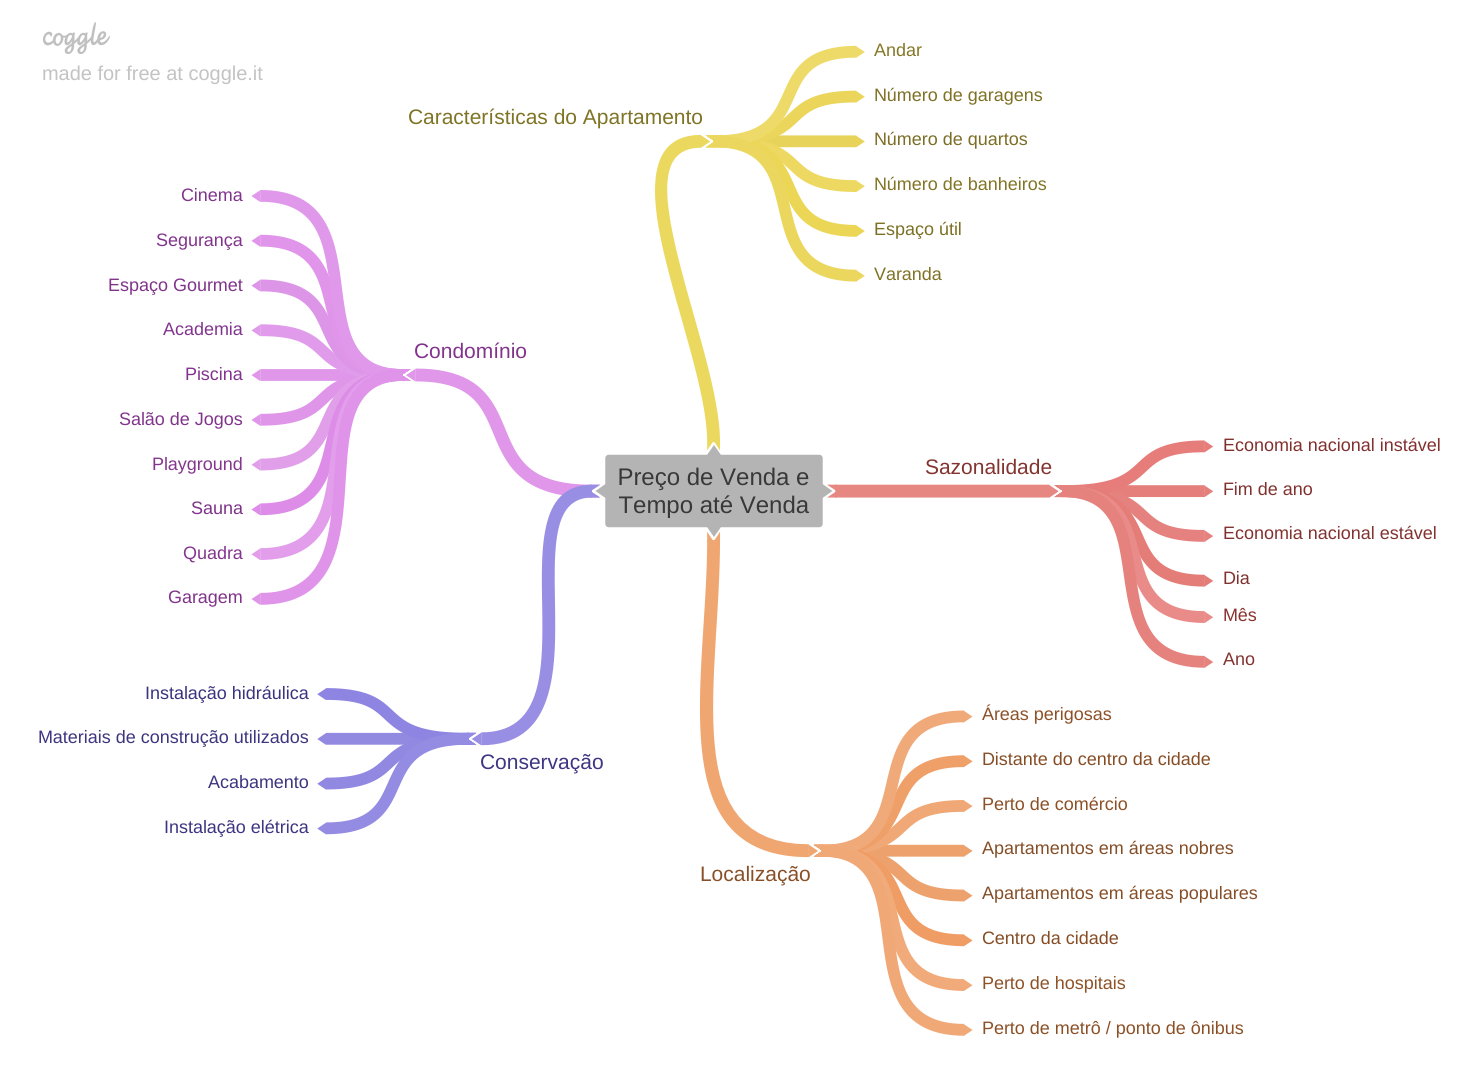

## 4.1. Criação de Hipóteses<a id='hipoteses'></a>

**Hipótese Interfenômenos**

**1.** Um maior preço de venda acarreta em uma menor liquidez (maior tempo no mercado).

**Hipóteses - Tamanho do Apartamento**

**1.** Apartamentos com mais cômodos tendem a ser mais caros.

**2.** Apartamentos com mais cômodos tendem a vender mais rapidamente.

**3.** Apartamentos com mais banheiros tendem a ser mais caros.

**4.** Apartamentos com mais banheiros tendem a vender mais rapidamente.

**5.** Apartamentos com maior área útil tendem a ser mais caros.

**6.** Apartamentos com maior área útil tendem a vender mais rapidamente.

**7.** Apartamentos com maior número de vagas de garagem tendem a ser mais caros.

**8.** Apartamentos com maior número de vagas de garagem tendem a vender mais rapidamente.


**Hipóteses - Sazonalidade**

**1.** Apartamentos durante épocas econômicas boas tendem a ser mais baratos.

**2.** Apartamentos durante épocas econômicas boas tendem a ser vendidos mais rapidamente.

**3.** Apartamentos durante épocas econômicas ruins tendem a ser mais caros.

**4.** Apartamentos durante épocas econômicas ruins tendem a demorar mais para serem vendidos.

**5.** Apartamentos durante o fim de ano tendem a ser mais caros.

**Hipóteses - Localização**

**1.** Apartamentos em áreas nobres tendem a ser mais caros.

**2.** Apartamentos em áreas nobres tendem a ser vendidos mais rapidamente.

**3.** Apartamentos em áreas populares tendem a ser mais baratos.

**4.** Apartamentos em áreas populares tendem a demorar mais para serem vendidos.

**5.** Apartamentos perto do centro da cidade tendem a ser mais caros.

**6.** Apartamentos perto do centro da cidade tendem a ser vendidos mais rapidamente.

**7.** Apartamentos perto de comércios tendem a ser mais caros.

**8.** Apartamentos perto de comércios tendem a ser vendidos mais rapidamente.

**Hipóteses - Conservação**

**1.** Apartamentos com melhor acabamento tendem a ser mais caros.

**2.** Apartamentos com melhor acabamento tendem a ser vendidos mais rapidamente.

**3.** Apartamentos com melhores instalações elétricas / hidráulicas tendem a ser mais caros.

**4.** Apartamentos com melhores instalações elétricas / hidráulicas tendem a ser vendidos mais rapidamente.

**Hipóteses - Condomínio**

**1.** Apartamentos cujo condomínio possui espaços de lazer tendem a ser mais caros.

**2.** Apartamentos cujo condomínio possui espaços de lazer tendem a ser vendidos mais rapidamente.

**3.** Apartamentos cujo condomínio possui academia tendem a ser mais caros.

**4.** Apartamentos cujo condomínio possui academia tendem a ser vendidos mais rapidamente.

**5.** Apartamentos cujo condomínio investe bastante na segurança tendem a ser mais caros.

**6.** Apartamentos cujo condomínio investe bastante na segurança tendem a ser vendidos mais rapidamente.

**Lista Final de Hipóteses**

Listadas as hipóteses, serão avaliadas apenas as possíveis com os dados atualmente disponíveis, ou então adaptadas, as quais são:

**1.** Um maior preço de venda acarreta em uma menor liquidez (maior tempo no mercado).

**2.** Apartamentos com mais cômodos tendem a ser mais caros.

**3.** Apartamentos com mais cômodos tendem a ser vendidos mais rapidamente.

**4.** Apartamentos com maior área útil tendem a ser mais caros.

**5.** Apartamentos com maior área útil tendem a ser vendidos mais rapidamente.

**6.** Apartamentos com maior número de vagas de garagem tendem a ser mais caros.

**7.** Apartamentos com maior número de vagas de garagem tendem a ser vendidos mais rapidamente.

**8.** Apartamentos com mais cômodos e garagem tendem a ser mais caros.

**9.** Apartamentos com mais cômodos e garagem tendem a ser vendidos mais rapidamente.

**10.** Apartamentos em determinadas áreas tendem a ser mais caros.

**11.** Apartamentos em determinadas áreas tendem a ser vendidos mais rapidamente.

**12.** Apartamentos em melhor estado de conservação tendem a ser mais caros.

**13.** Apartamentos em melhor estado de conservação tendem a ser vendidos mais rapidamente.

## 4.2. Novas Features<a id='novas_features'></a>

Para validar as hipóteses, é criada a nova feature:

* rooms_garage : Esta é simplesmente a soma das features garage e rooms.
* lat_long_bins : abstração de latitude e longitude em categorias

In [11]:
# rooms_garages = rooms + garage
df4['rooms_garages'] = df4['rooms'] + df4['garages']

# lat long - categorias
lat_bins = pd.qcut(df4['latitude'], 3, labels = False).astype(str)
long_bins = pd.qcut(df4['longitude'], 3, labels = False).astype(str)

lat_bins_label = pd.qcut(df4['latitude'], 3)
long_bins_label = pd.qcut(df4['longitude'], 3)

df4['lat_long_bins'] = lat_bins + long_bins

df4.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,time_on_market,sold,rooms_garages,lat_long_bins
0,3.0,2.0,77,-23.624629,-46.738757,686126,2,75.838273,0,5.0,00
1,1.0,1.0,35,-23.553170,-46.648687,675152,3,215.490618,0,2.0,22
2,3.0,2.0,97,-23.607094,-46.634414,871258,2,92.048200,0,5.0,02
3,3.0,3.0,102,-23.539732,-46.567559,648740,3,32.000000,1,6.0,22
4,2.0,1.0,78,-23.591993,-46.625481,968643,2,319.570866,0,3.0,12


In [12]:
# salvando lat e long bins para uso posterior
with open("./parameters/lat_bins.npy", "wb") as file:
    np.save(file, np.array(lat_bins_label.unique()))

with open("./parameters/long_bins.npy", "wb") as file:
    np.save(file, np.array(long_bins_label.unique()))

# 5. Análise Exploratória de Dados<a id='analise_exploratoria'></a>

In [13]:
df5 = df4.copy()

## 5.1. Análise Univariada<a id='analise_univariada'></a>

### 5.1.1. Variáveis Dependentes<a id='variaveis_dependentes'></a>

Foram analisados individualmente os dados de preço e data no mercado, seccionando aqueles que foram vendidos daqueles que ainda não foram, para avaliar suas distribuições.

Observa-se que, referente ao preço dos apartamentos, a distribuição, tanto para apartamentos vendidos quanto não vendidos tendem a possuir valores concentrados à esquerda da média. Já em relação ao tempo no mercado, verifica-se que há uma clara queda no tempo de mercado referente a apartamentos vendidos, enquanto o mesmo não acontece para apartamentos que ainda não foram vendidos. 

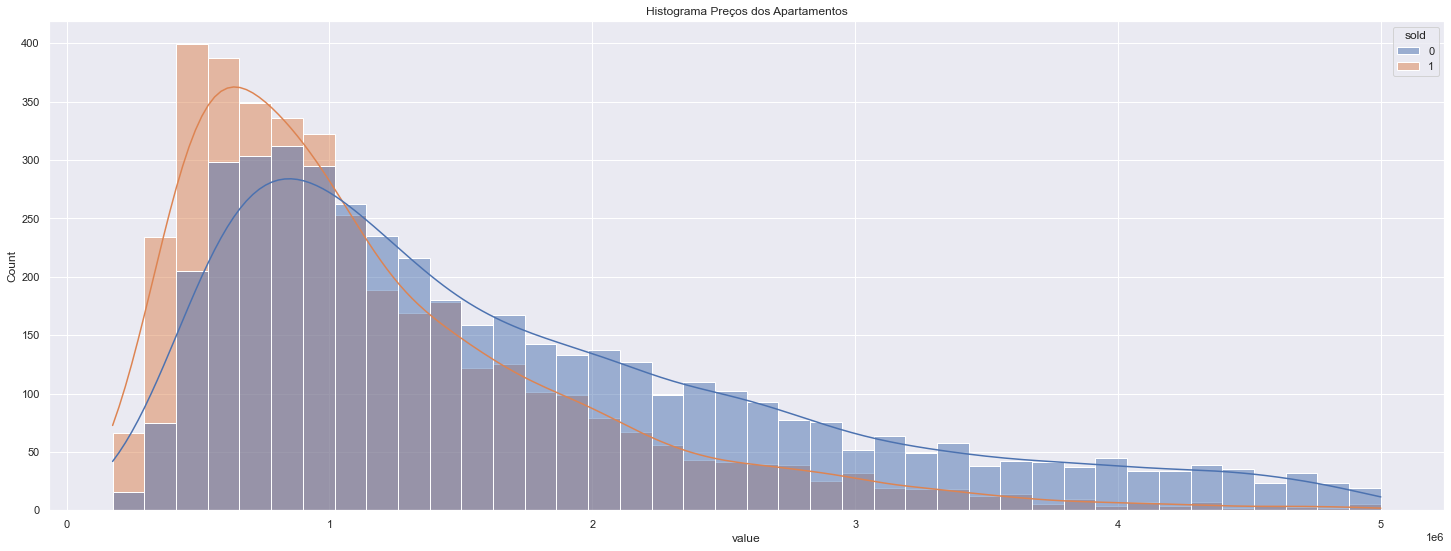

In [14]:
# histograma dos preços
sns.histplot(x = 'value', data = df5, kde = True, hue = 'sold');
plt.title('Histograma Preços dos Apartamentos');

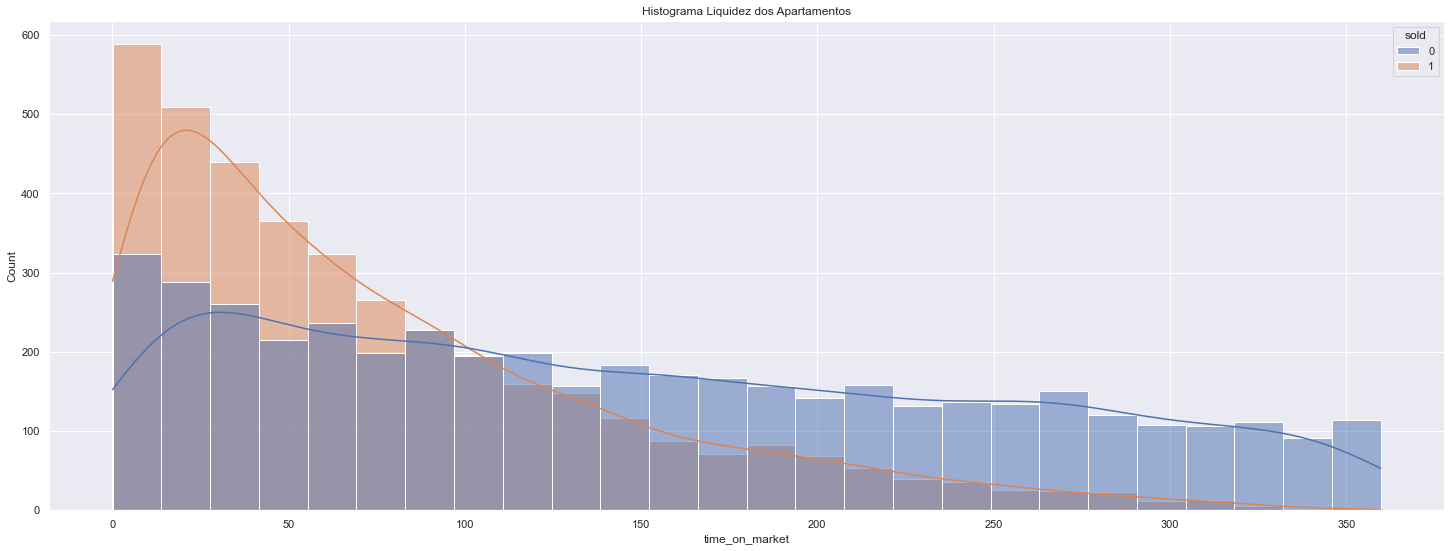

In [15]:
# histograma da liquidez
sns.histplot(x = 'time_on_market', data = df5, kde = True, hue = 'sold');
plt.title('Histograma Liquidez dos Apartamentos');

### 5.1.2. Variáveis Independentes<a id='variaveis_independentes'></a>

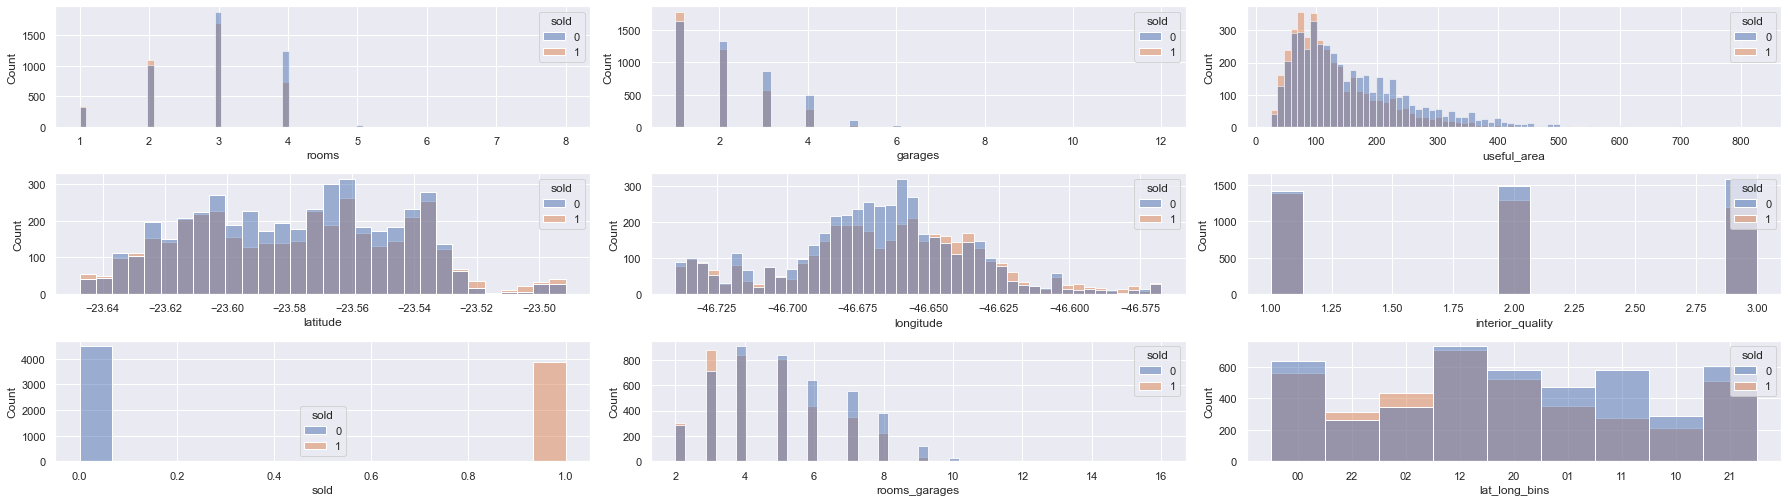

In [16]:
columns = df5.columns.to_list()
columns.remove('value')
columns.remove('time_on_market')
for i, column in enumerate(columns, 1):
    plt.subplot(4,3,i);
    sns.histplot(x = column, data = df5, hue = 'sold');
plt.tight_layout();

Em todos o comportamento dos dados de apartamentos vendidos e não vendidos é praticamente o mesmo, exceto no gráfico de interior_quality, onde a quantidade de apartamentos vendidos diminui para maior valores de conservação, enquanto o a volumetria para apartamentos não vendidos aumenta com o nível de conservação.

## 5.2. Análise Bivariada<a id='analise_bivariada'></a>

### H1. Um maior preço de venda acarreta em uma menor liquidez (maior tempo no mercado) - Fraca

**Falso**. Não necessariamente, não é possível concluir se um apartamento com maior preço possui uma menor liquidez.

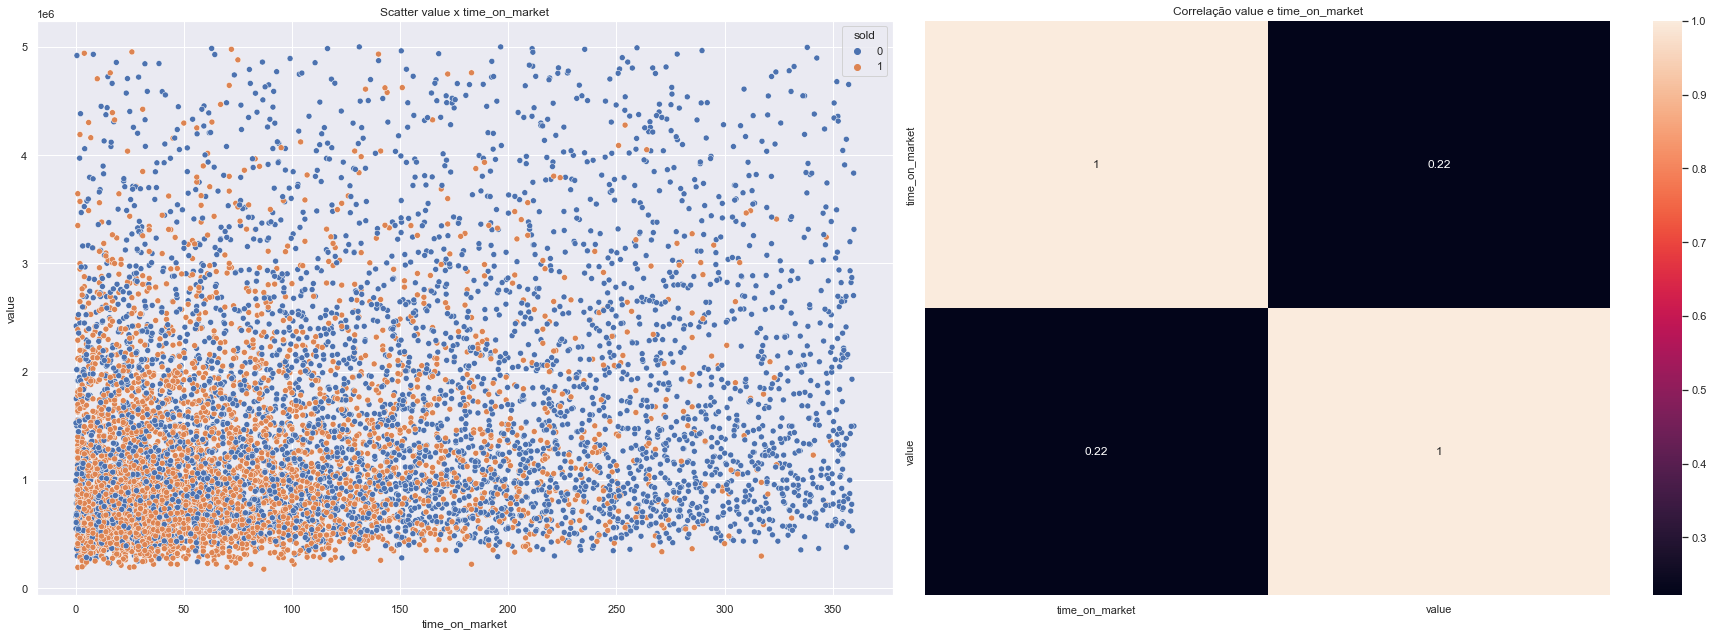

In [17]:
plot_hypothesis(df5, 'time_on_market', 'value', 'sold', titles = ['Scatter value x time_on_market', 'Correlação value e time_on_market'])

### H2. Apartamentos com mais cômodos tendem a ser mais caros - Forte

**Verdadeiro**. Há um aumento significativo no preço dos apartamentos com o aumento de número de cômodos. É possível notar também que, para uma mesma quantidade de cômodos, os apartamentos não vendidos costumam ser mais caros.

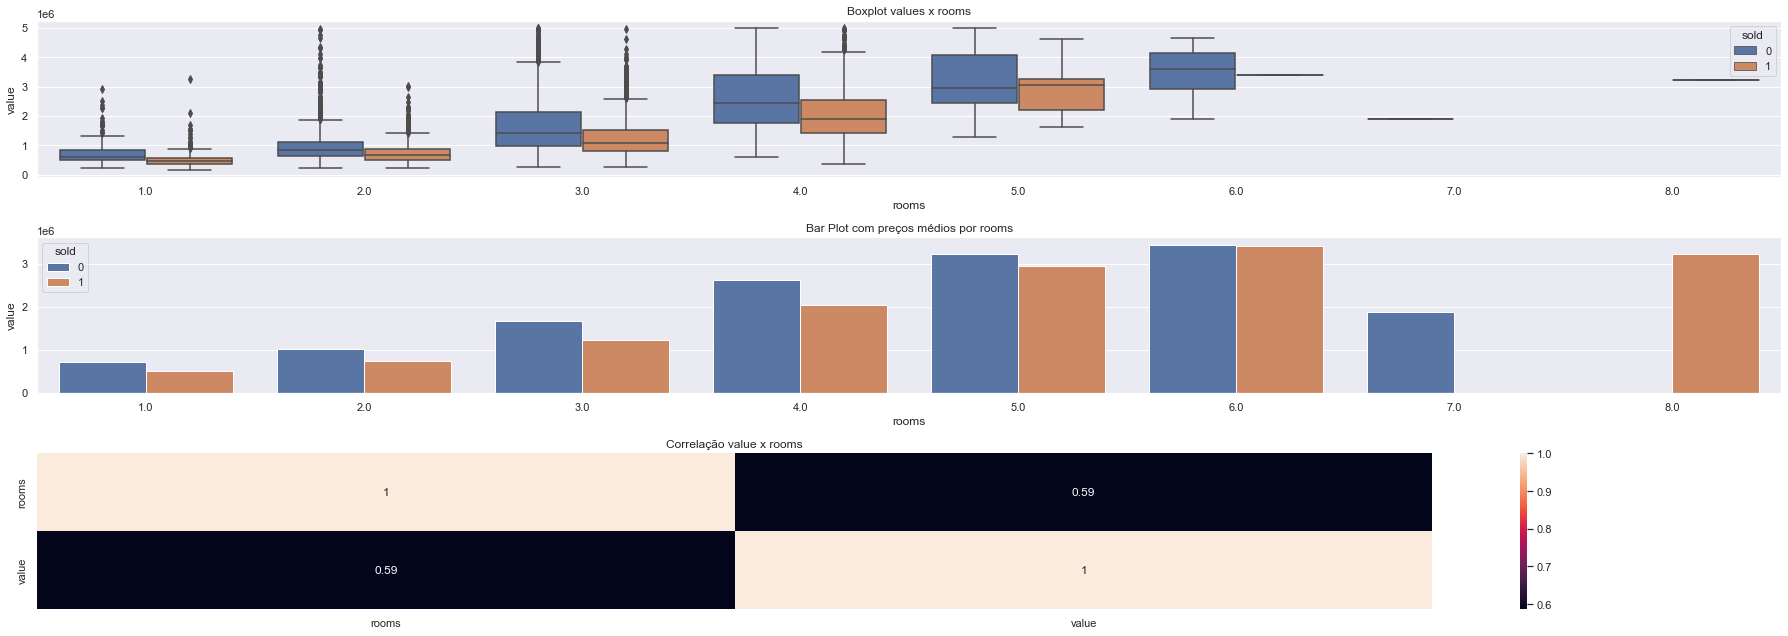

In [18]:
plot_hypothesis(df5, 'rooms', 'value', 'sold', categorical = True, titles = ['Boxplot values x rooms', 
                                                                             'Bar Plot com preços médios por rooms', 
                                                                             'Correlação value x rooms'])

### H3. Apartamentos com mais cômodos tendem a ser vendidos mais rapidamente - Fraca

**Falso**. O número de cômodos praticamente não interfere na liquidez do apartamento. Ainda assim, é possível verificar que, para apartamentos com mesmo número de cômodos, o tempo no mercado é maior para aqueles não vendidos.

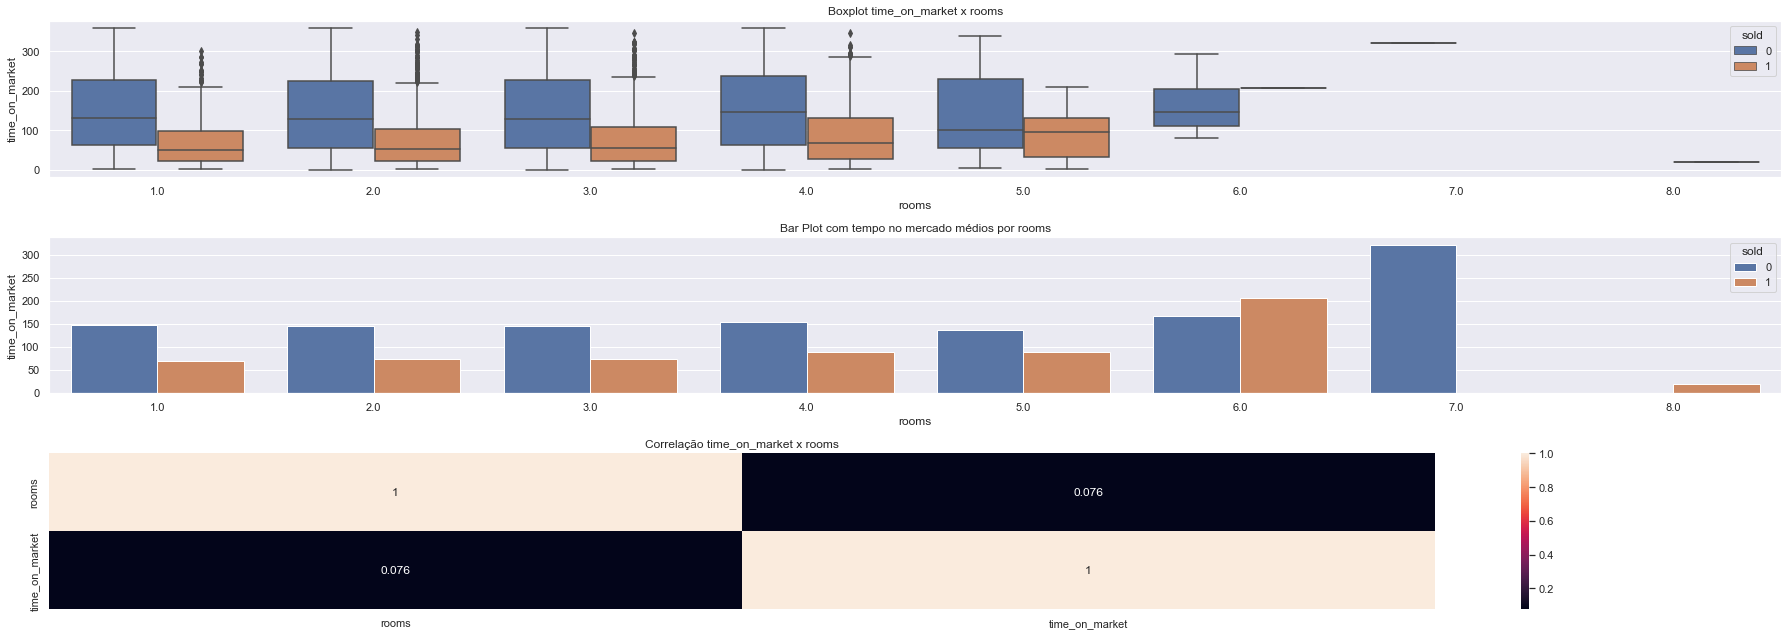

In [19]:
plot_hypothesis(df5, 'rooms', 'time_on_market', 'sold', categorical = True, titles = ['Boxplot time_on_market x rooms', 
                                                                                     'Bar Plot com tempo no mercado médios por rooms', 
                                                                                     'Correlação time_on_market x rooms'])

### H4. Apartamentos com maior área útil tendem a ser mais caros - Forte

**Verdadeiro**. Observa-se forte correlação linear para área útil e preço de venda, sendo esta uma variável super importante para o modelo a ser construído.

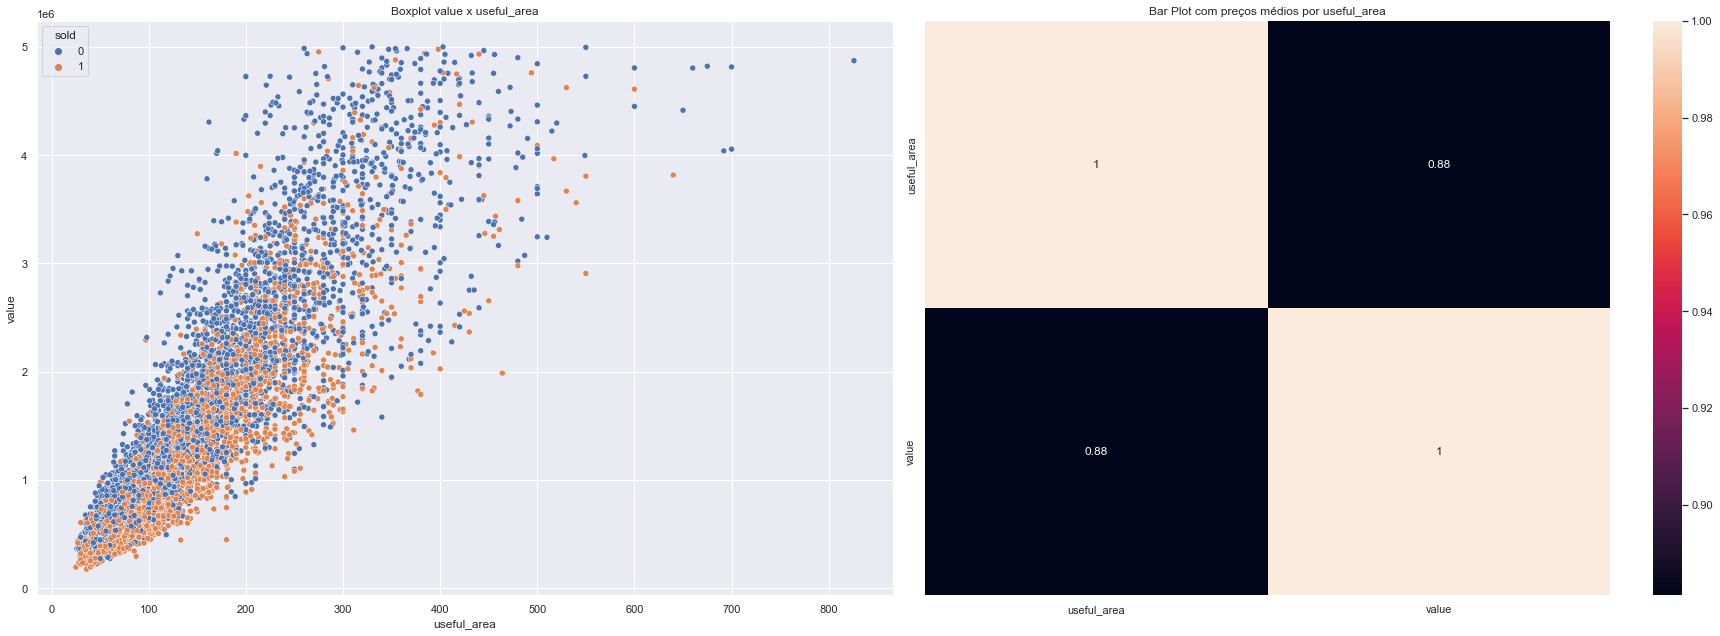

In [20]:
plot_hypothesis(df5, 'useful_area', 'value', 'sold', titles = ['Boxplot value x useful_area', 
                                                               'Bar Plot com preços médios por useful_area', 
                                                               'Correlação value x useful_area'])

### H5. Apartamentos com maior área útil tendem a ser vendidos mais rapidamente - Fraca

**Falsa**. Há uma fraca correlação entre área útil do apartamento e sua liquidez. Novamente, é possível verificar a tendência de apartamentos não vendidos possuir menor liquidez.

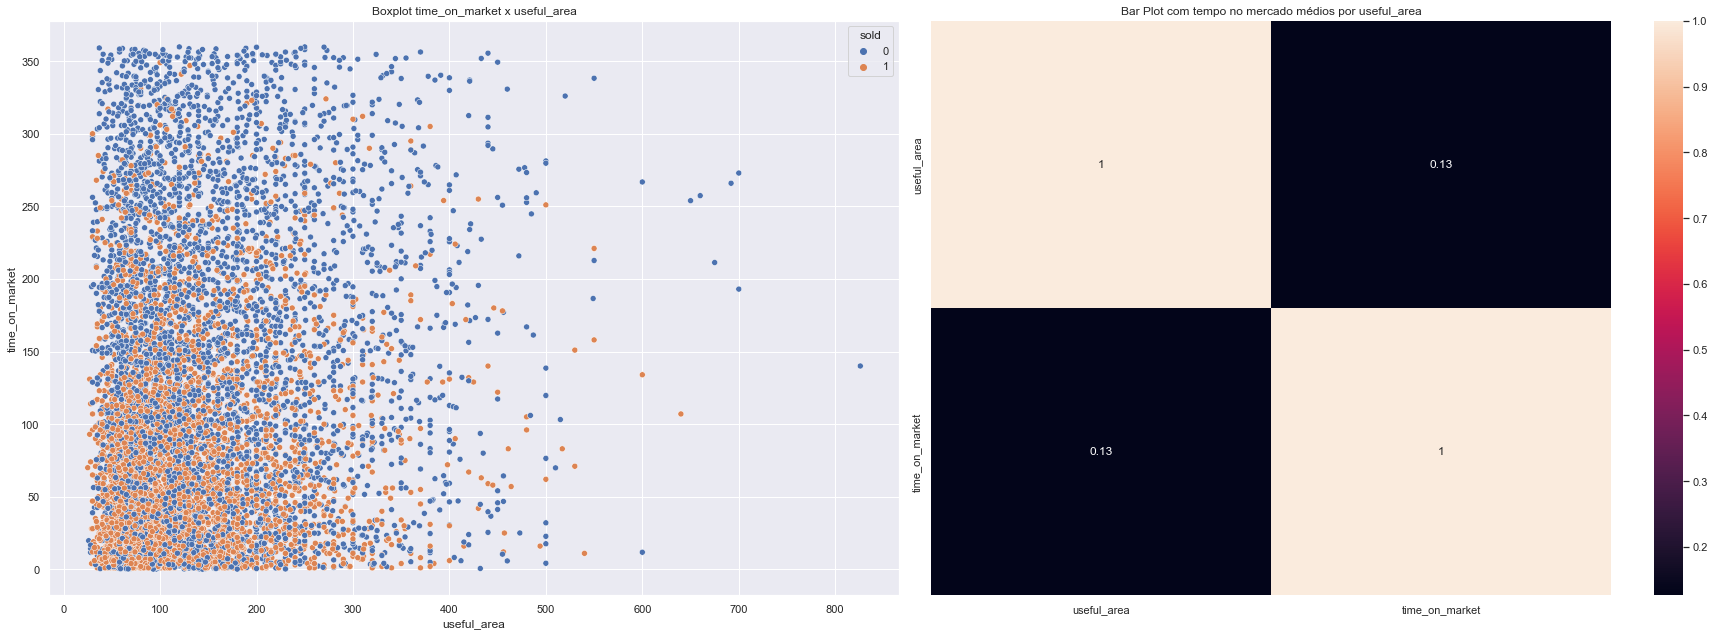

In [21]:
plot_hypothesis(df5, 'useful_area', 'time_on_market', 'sold',  titles = ['Boxplot time_on_market x useful_area', 
                                                                       'Bar Plot com tempo no mercado médios por useful_area', 
                                                                       'Correlação time_on_market x useful_area'])

### H6. Apartamentos com maior número de vagas de garagem tendem a ser mais caros - Forte

**Verdadeira**. Verifica-se uma tendência significativa de aumento no preço do apartamento com a existência de mais vagas na garagem.

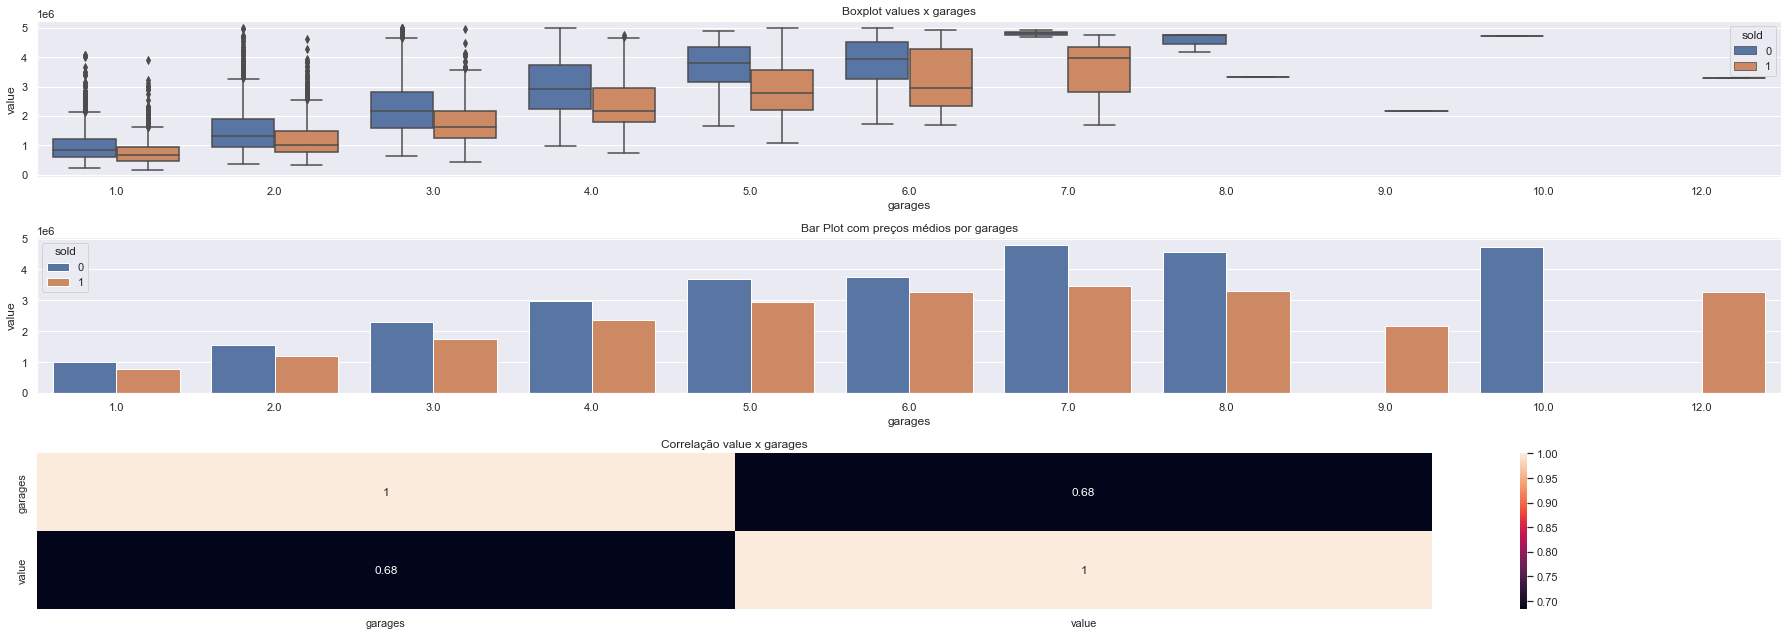

In [22]:
plot_hypothesis(df5, 'garages', 'value', 'sold', categorical = True, titles = ['Boxplot values x garages', 
                                                                             'Bar Plot com preços médios por garages', 
                                                                             'Correlação value x garages'])

### H7. Apartamentos com maior número de vagas de garagem tendem a ser vendidos mais rapidamente - Fraca

**Falsa**. O número de vagas nas garagens não impacta na liquidez do apartamento.

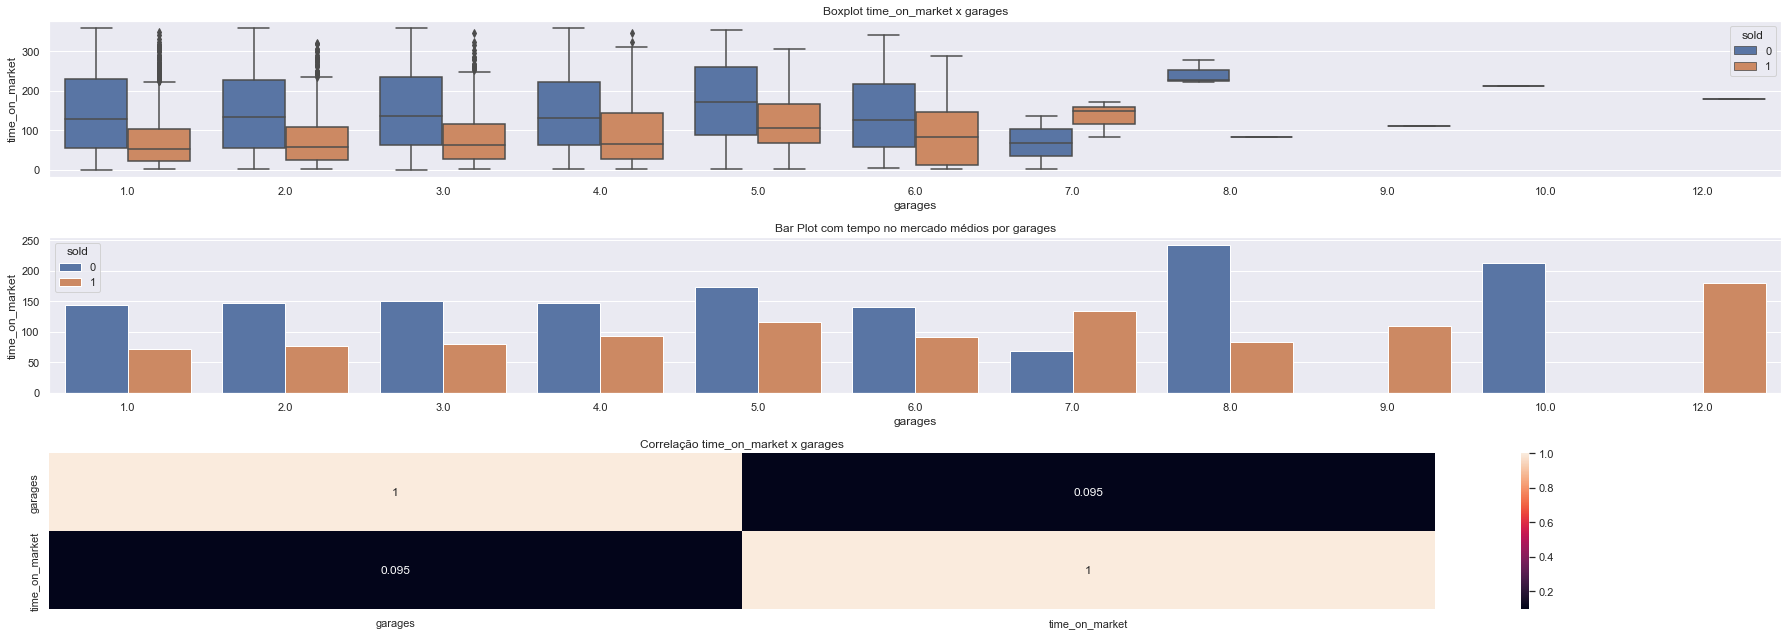

In [23]:
plot_hypothesis(df5, 'garages', 'time_on_market', 'sold', categorical = True, titles = ['Boxplot time_on_market x garages', 
                                                                                     'Bar Plot com tempo no mercado médios por garages', 
                                                                                     'Correlação time_on_market x garages'])

### H8. Apartamentos com mais cômodos e garagem tendem a ser mais caros - Forte

**Verdadeiro**. O número de garagens e cômodos somados apresenta uma correlação maior com o preço do apartamento do que as variáveis sozinhas.

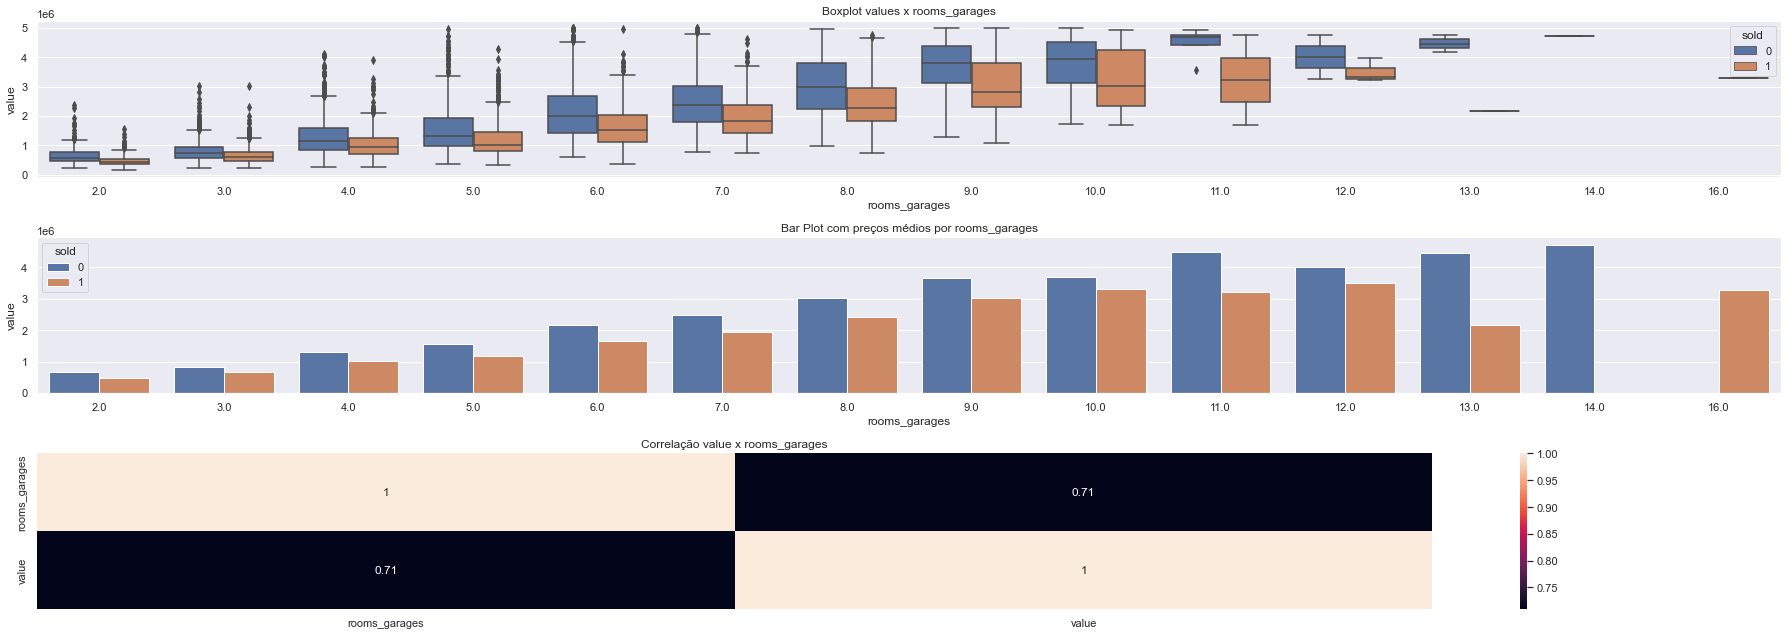

In [24]:
plot_hypothesis(df5, 'rooms_garages', 'value', 'sold', categorical = True, titles = ['Boxplot values x rooms_garages', 
                                                                                     'Bar Plot com preços médios por rooms_garages', 
                                                                                     'Correlação value x rooms_garages'])

### H9. Apartamentos com mais cômodos e garagem tendem a ser vendidos mais rapidamente - Fraca

**Falso**. Como esperado, a soma de vagas na garagem com cômodos na casa não possui relação com a liquidez do apartamento. Curioso notar que para 11 cômodos + vagas na garagem, o preço dos apartamentos vendidos supera o dos não vendidos.

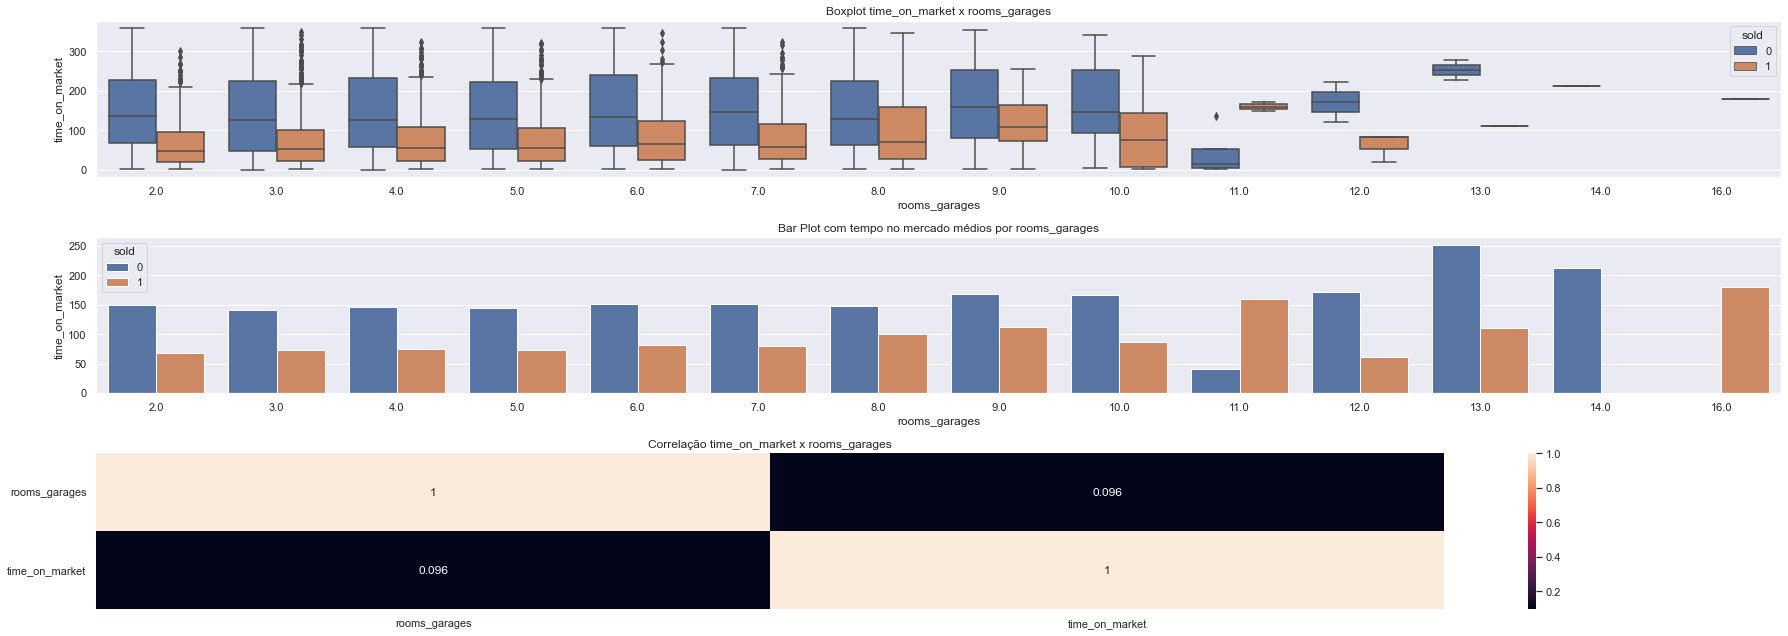

In [25]:
plot_hypothesis(df5, 'rooms_garages', 'time_on_market', 'sold', categorical = True, titles = ['Boxplot time_on_market x rooms_garages', 
                                                                                     'Bar Plot com tempo no mercado médios por rooms_garages', 
                                                                                     'Correlação time_on_market x rooms_garages'])

### H10. Apartamentos em determinadas áreas tendem a ser mais caros - Fraca

**Verdadeiro**. Embora não seja linear, é possível verificar regiões cujos preços de apartamentos são relativamente maiores que outras.

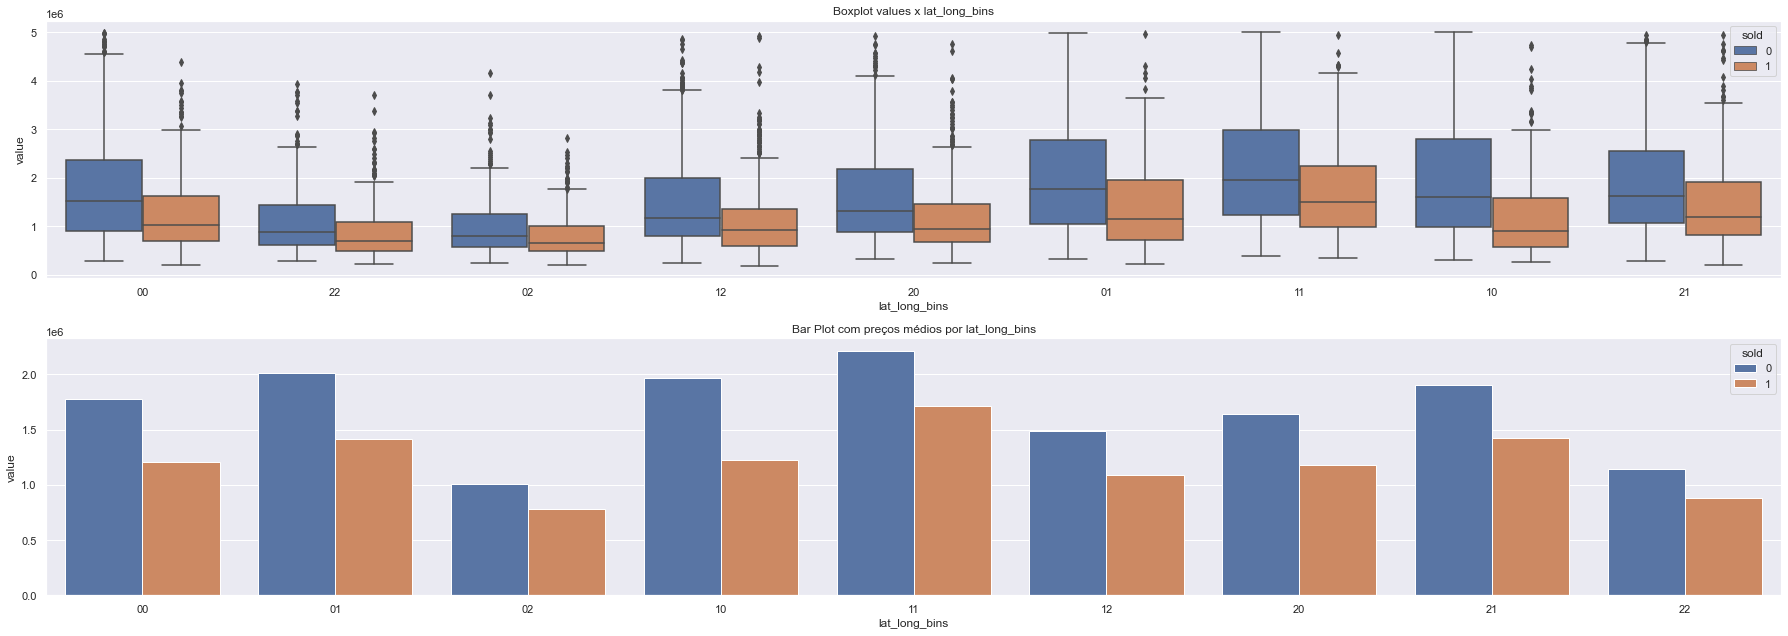

In [26]:
plot_hypothesis(df5, 'lat_long_bins', 'value', 'sold', categorical = True, titles = ['Boxplot values x lat_long_bins', 
                                                                                     'Bar Plot com preços médios por lat_long_bins'], corr = False)

### H11. Apartamentos em determinadas áreas tendem a ser vendidos mais rapidamente - Fraca

**Falso**. A área onde se encontra o apartamento não influencia a liquidez do apartamento.

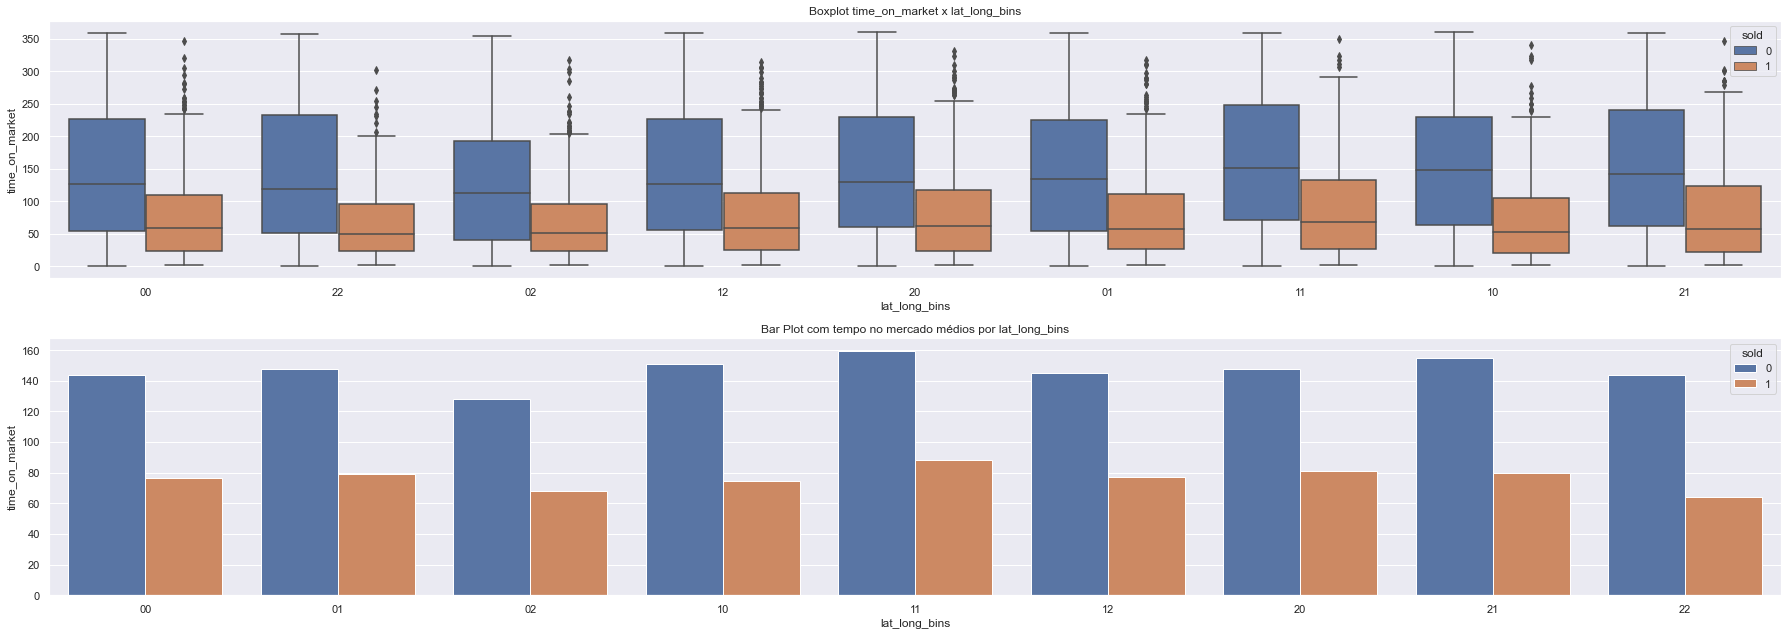

In [27]:
plot_hypothesis(df5, 'lat_long_bins', 'time_on_market', 'sold', categorical = True, titles = ['Boxplot time_on_market x lat_long_bins', 
                                                                                     'Bar Plot com tempo no mercado médios por lat_long_bins'], corr = False)

### H12. Apartamentos em melhor estado de conservação tendem a ser mais caros - Forte

**Falso**. O estado de conservação do apartamento não influencia seu preço. Isto pode ser importante, visto que pode fazer com que a reforma na compra de um apartamento não seja necessária para a revenda.

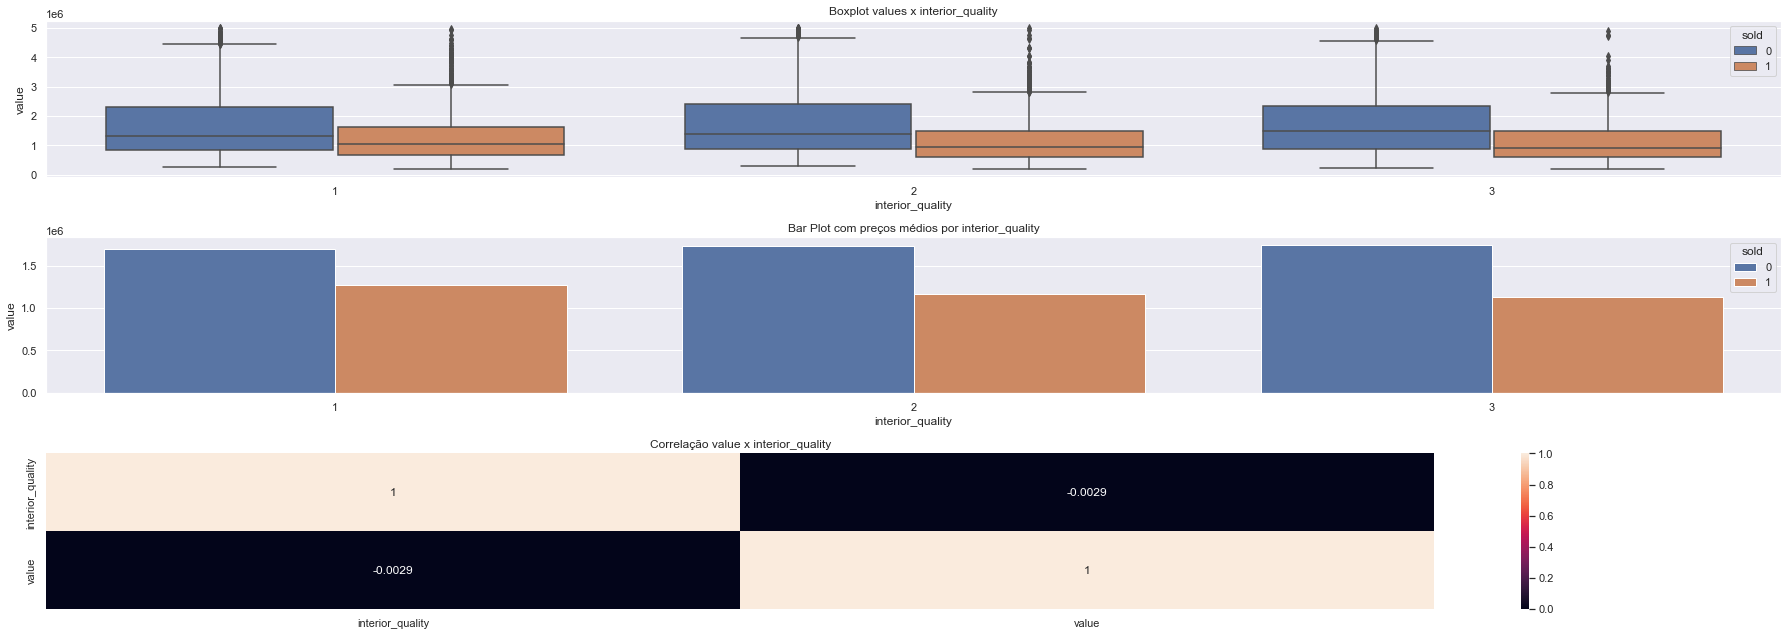

In [28]:
plot_hypothesis(df5, 'interior_quality', 'value', 'sold', categorical = True, titles = ['Boxplot values x interior_quality', 
                                                                                     'Bar Plot com preços médios por interior_quality', 
                                                                                     'Correlação value x interior_quality'])

### H13. Apartamentos em melhor estado de conservação tendem a ser vendidos mais rapidamente - Forte

**Falsa**. O estado de conservação do apartamento não influencia em sua liquidez. Outro indício que talvez não seja necessário reformar o apartamento na hora da revenda.

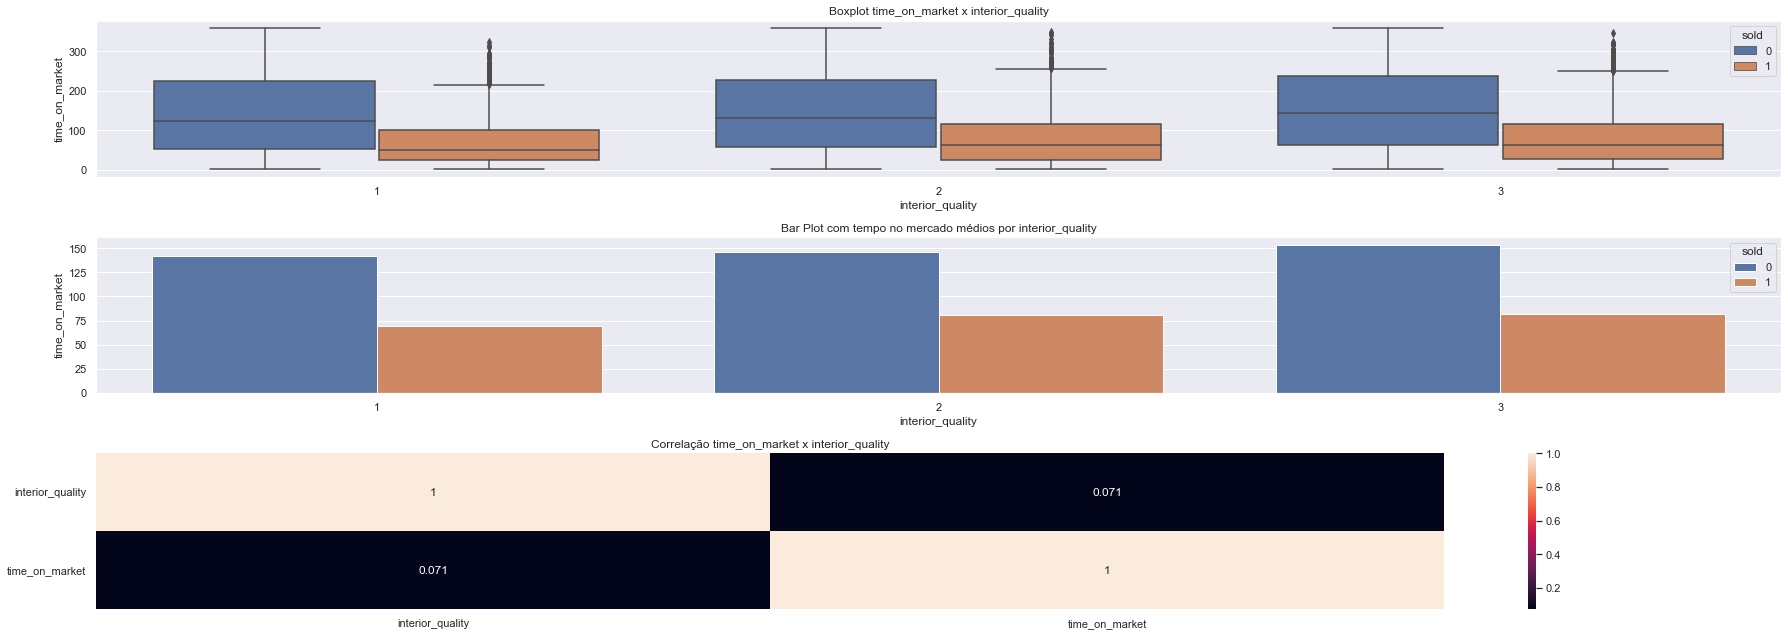

In [29]:
plot_hypothesis(df5, 'interior_quality', 'time_on_market', 'sold', categorical = True, titles = ['Boxplot time_on_market x interior_quality', 
                                                                                     'Bar Plot com tempo no mercado médios por interior_quality', 
                                                                                     'Correlação time_on_market x interior_quality'])

## 5.3. Análise Multivariada<a id='analise_multivariada'></a>

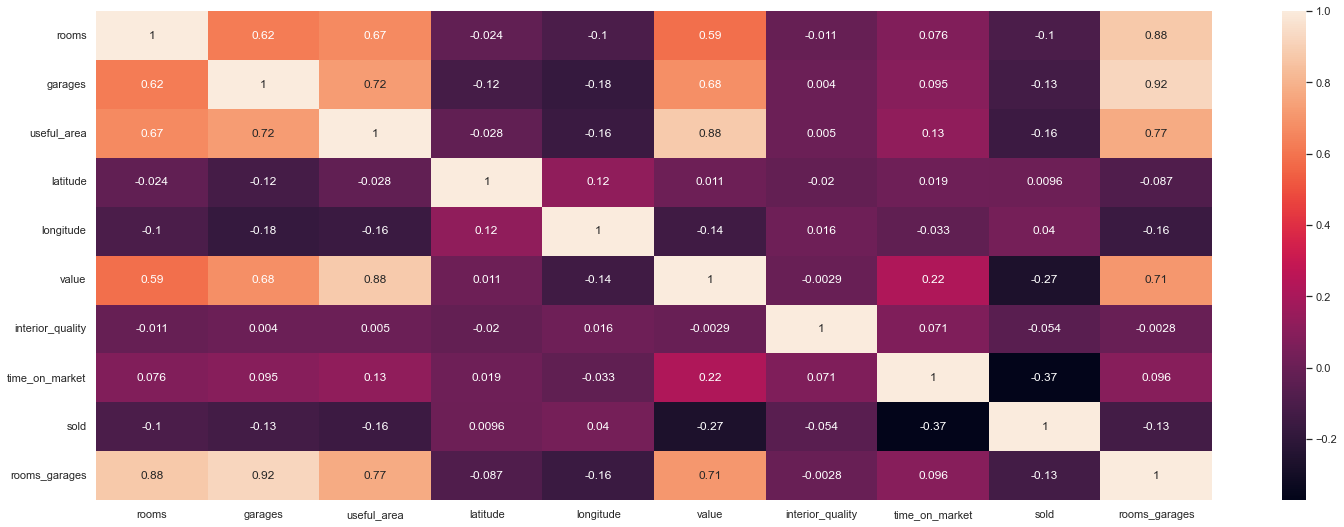

In [30]:
# construcao do heatmap de correlacoes
correlation = df5.drop(columns = 'lat_long_bins').corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

Observa-se que as principais features correlacionadas ao preço do apartamento são, em ordem decrescente de correlação, useful_area (0.88), rooms_garages(0.71), garages (0.68) e rooms (0.59). Contudo, verifica-se que há também correlação entre essas features independentes, como rooms_garages estar altamente correlacionado com rooms e garages, o que faz sentido, dado que criamos essa feature a partir dessas outras duas, mas também com useful_area. Assim, deve-se, na seleção de features para o modelo, levar em conta tais informações.

# 6. Análise de Sobrevivência<a id='analise_de_sobrevivencia'></a>

Para a análise de sobrevivência a variável de interesse principal será o time_on_market, avaliando quantos dias um apartamento ficará no mercado até sua venda, a partir de variáveis independentes.

In [31]:
df6 = df5.copy()

## 6.1. Teoria - Análise de Sobrevivência<a id='teoria_sobrevivencia'></a>

### Tempo de Sobrevivência: tempo até que apartamento seja vendido

Três tipos de eventos em análise de sobrevivência:

1. Recaída: deteriorização do estado do objeto ao longo do tempo. Aqui isto se relaciona ao preço do apartamento ao longo dos dias no mercado.

2. Progressão: processo de avançar no tempo, chegando cada vez mais próximo do evento de interesse, aqui definido como venda do apartamento.

3. Morte: fim do evento observado, no caso é o momento da venda do apartamento.

### Censura

Há a probabilidade de que eventos de interesse não ocorram, sendo que tais observações são chamadas de observações censuradas. Existem 3 tipos de censura:

1. Censura de direita: o evento avaliado ainda não ocorreu, assim, não temos o tempo que o evento demorou para ocorrer.

2. Censura de esquerda: eventos que não podem ser observados por alguma causa.

3. Censura de intervalo: só há dados para um intervalo específico, sendo que o evento de interesse pode não ocorrer durante este tempo.

### Sobrevivência e Funções de Risco (Hazard)

1. Função de Sobrevivência: Estimador de Kaplan-Meier. Probabilidade que uma observação sobreviva do tempo origem até um tempo futuro $t$.

2. Função de Hazard: probabilidade que o evento ocorra no instante de tempo $t$ para uma determinada observação.

Probabilidade de sobrevivência no tempo $t_i$:
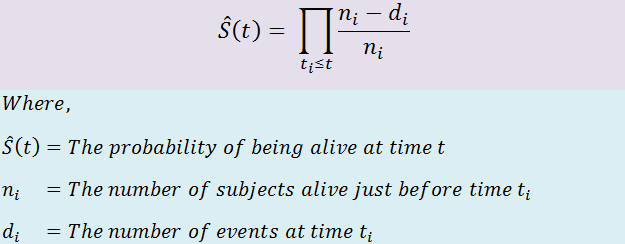

Cuidados com Kaplan-Meier:

* Kaplan-Meier não realiza análises com variáveis contínuas, apenas entre grupos

## 6.2. Função de Sobrevivência - Kaplan-Meier<a id='kaplan-meier'></a>

* **event_at**: guarda valor de tempo do dataset, ou seja, quando o apartamento foi avaliado se foi vendido ou não. É medido em dias.

* **observed**: número de apartamentos vendidos em um periodo de tempo.

* **censored**: apartamentos censurados até tal data, ou seja, apartamentos que estão na base e ainda não foram vendidos até tal data.

* **removed**: número de apartamentos que já foram vendidos.

* **entrance**: novos apartamentos que são considerados. Neste caso, este número é fixo.

* **at_risk**: número de apartamentos ainda em observação. 

In [32]:
# instanciar modelo
kmf = KaplanMeierFitter()

# fit de parametros
kmf.fit(durations = df6['time_on_market'], event_observed = df6['sold'])

# tabela de eventos
kmf.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.000000,0,0,0,8369,8369
0.097116,1,0,1,0,8369
0.142505,1,0,1,0,8368
0.143296,1,0,1,0,8367
0.176028,1,0,1,0,8366


###  6.2.1. Gráfico de Kaplan-Meier<a id='grafico_kaplan'></a>

A partir da estimativa de Kaplan-Meier é possível avaliar a probabilidade de venda de um apartamento considerando a quantidade de dias no mercado, a partir de sua densidade cumulativa de probabilidades. Verifica-se que, a medida que o tempo passa, a tendência de o apartamento vender cresce, chegando a, aproximadamente, 60% de probabilidade de venda passados 250 dias no mercado, indicando que 60% das casas seriam vendidas até esse período de tempo. Os intervalos de confiança são calculados a partir da fórmula exponencial de Greenwood.

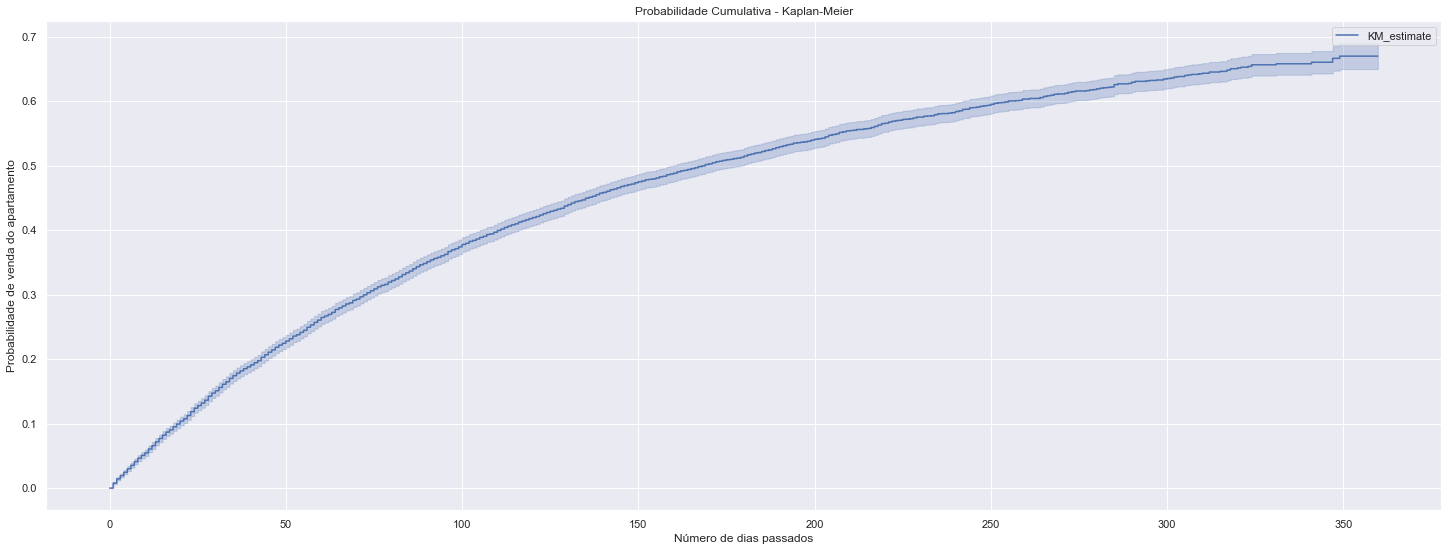

In [33]:
# Kaplan-Meier plot
kmf.plot_cumulative_density();
plt.title("Probabilidade Cumulativa - Kaplan-Meier");
plt.xlabel("Número de dias passados");
plt.ylabel("Probabilidade de venda do apartamento");

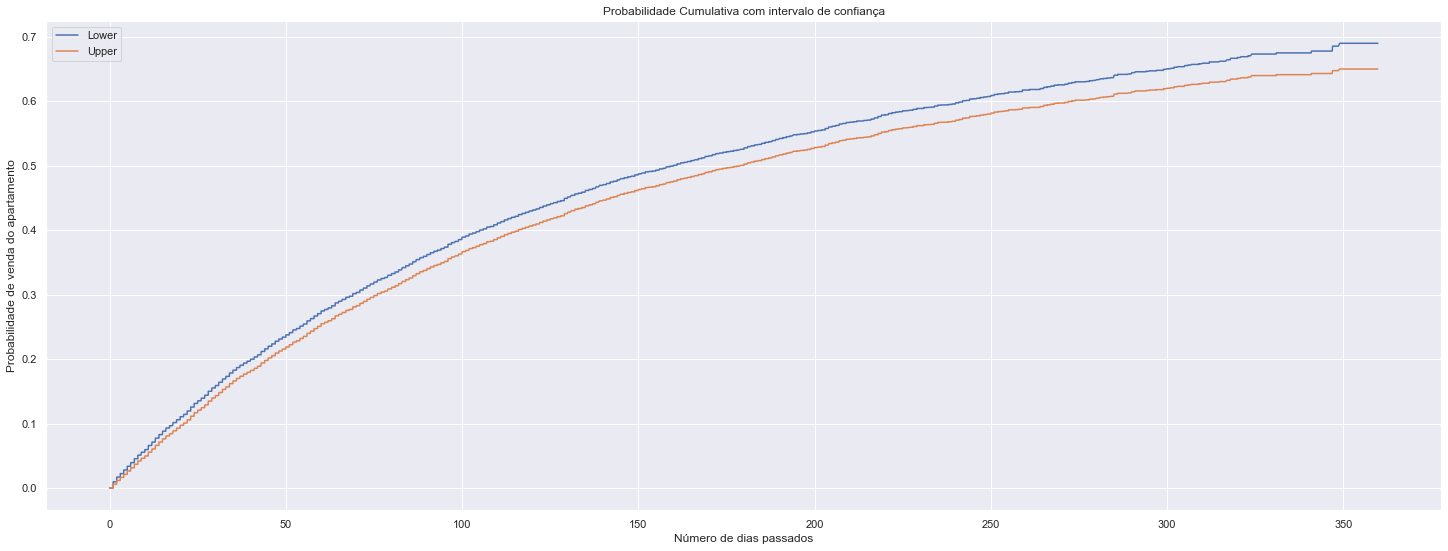

In [34]:
# gráfico com intervalos de confiança de 95%
cumulative_density = kmf.confidence_interval_cumulative_density_

plt.plot(cumulative_density["KM_estimate_lower_0.95"], label = "Lower");
plt.plot(cumulative_density["KM_estimate_upper_0.95"], label = "Upper");
plt.title("Probabilidade Cumulativa com intervalo de confiança");
plt.xlabel("Número de dias passados");
plt.ylabel("Probabilidade de venda do apartamento");
plt.legend();

## 6.3. Kaplan-Meier por estado de conservação<a id='kaplan_conservacao'></a>

Agora, será calculada a probabilidade de um apartamento ser vendido considerando seu estado de conservação, para avaliar o real impacto desta variável.

In [35]:
# instanciar modelos
kmf_1 = KaplanMeierFitter()
kmf_2 = KaplanMeierFitter()
kmf_3 = KaplanMeierFitter()

In [36]:
# seccionando grupos
quality_1 = df6.loc[df6['interior_quality'] == 1].reset_index(drop = True).copy()
quality_2 = df6.loc[df6['interior_quality'] == 2].reset_index(drop = True).copy()
quality_3 = df6.loc[df6['interior_quality'] == 3].reset_index(drop = True).copy()

In [37]:
# fit dos modelos
kmf_1.fit(durations = quality_1['time_on_market'], event_observed = quality_1['sold'], label = '1')
kmf_2.fit(durations = quality_2['time_on_market'], event_observed = quality_2['sold'], label = '2')
kmf_3.fit(durations = quality_3['time_on_market'], event_observed = quality_3['sold'], label = '3')

<lifelines.KaplanMeierFitter:"3", fitted with 2772 total observations, 1580 right-censored observations>

### 6.3.1. Gráfico Kaplan-Meier por estado de conservação<a id='grafico_kaplan_conservacao'></a>

Contra a intuição, verifica-se que apartamentos com pior estado de conservação possuem maiores probabilidades acumuladas para sua venda ao longo dos dias no mercado.

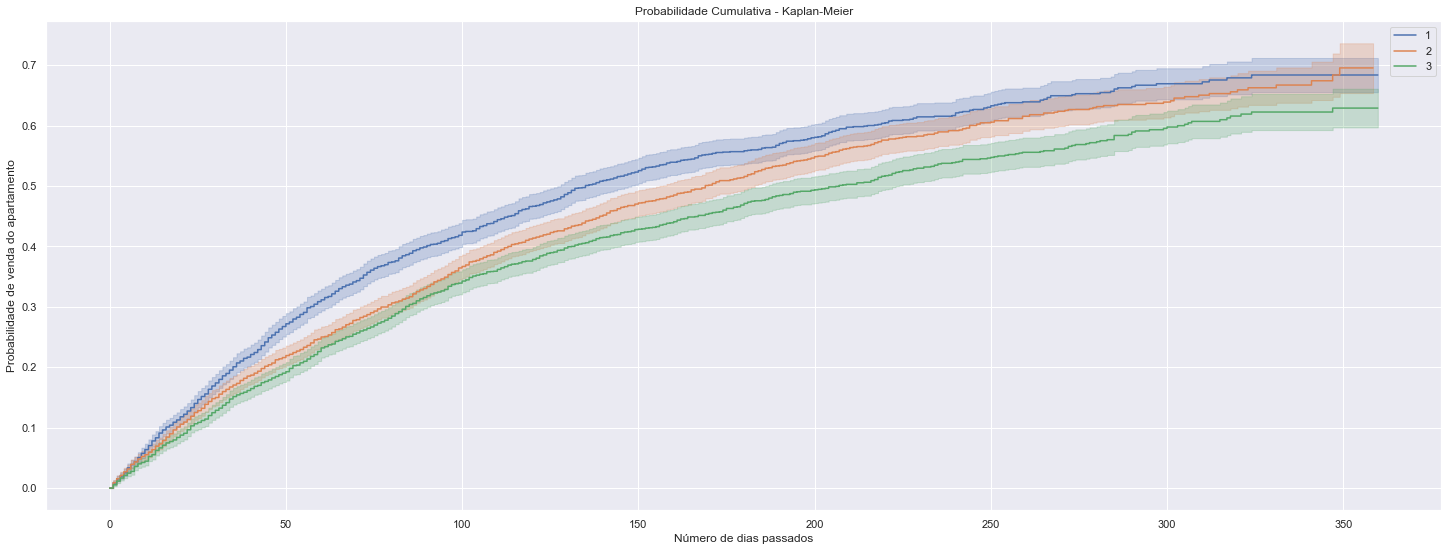

In [38]:
# gráficos kaplan meier com grupos
kmf_1.plot_cumulative_density();
kmf_2.plot_cumulative_density();
kmf_3.plot_cumulative_density();

plt.title("Probabilidade Cumulativa - Kaplan-Meier");
plt.xlabel("Número de dias passados");
plt.ylabel("Probabilidade de venda do apartamento");

## 6.4. Kaplan-Meier por estado de conservação e por preço<a id='kaplan_conservacao_preco'></a>

Como o Kaplan-Meier compara apenas probabilidades entre grupos, os preços serão seccionados da seguinte maneira:

* Categoria 1 - Barato: preço <= 500.000
* Categoria 2 - Médio:  500.000 < preço <= 1.000.000
* Categoria 3 - Caro: preço > 1.000.000

E, juntamente com cada categoria de conservação, serão avaliadas suas probabilidades.

In [39]:
# criando categorias de preco
aux = df6.copy()
aux['categoria_preco'] = aux['value'].apply(lambda x: 1 if x <= 500000 else 2 if (x > 500000) and (x <= 1000000) else 3)

# categoria conservacao + preco
aux['categoria_conservacao_preco'] = aux['interior_quality'].astype(str) + aux['categoria_preco'].astype(str)

In [40]:
# instanciar modelos
kmf_1 = KaplanMeierFitter()
kmf_2 = KaplanMeierFitter()
kmf_3 = KaplanMeierFitter()
kmf_4 = KaplanMeierFitter()
kmf_5 = KaplanMeierFitter()
kmf_6 = KaplanMeierFitter()
kmf_7 = KaplanMeierFitter()
kmf_8 = KaplanMeierFitter()
kmf_9 = KaplanMeierFitter()

In [41]:
# seccionando grupos
cons1 = aux['interior_quality'] == 1
cons2 = aux['interior_quality'] == 2
cons3 = aux['interior_quality'] == 3
price1 = aux['categoria_preco'] == 1
price2 = aux['categoria_preco'] == 2
price3 = aux['categoria_preco'] == 3

cons_1_price_1 = aux.loc[cons1 & price1].reset_index(drop = True).copy()
cons_1_price_2 = aux.loc[cons1 & price2].reset_index(drop = True).copy()
cons_1_price_3 = aux.loc[cons1 & price3].reset_index(drop = True).copy()
cons_2_price_1 = aux.loc[cons2 & price1].reset_index(drop = True).copy()
cons_2_price_2 = aux.loc[cons2 & price2].reset_index(drop = True).copy()
cons_2_price_3 = aux.loc[cons2 & price3].reset_index(drop = True).copy()
cons_3_price_1 = aux.loc[cons3 & price1].reset_index(drop = True).copy()
cons_3_price_2 = aux.loc[cons3 & price2].reset_index(drop = True).copy()
cons_3_price_3 = aux.loc[cons3 & price3].reset_index(drop = True).copy()

In [42]:
# fit dos modelos
kmf_1.fit(durations = cons_1_price_1['time_on_market'], event_observed = cons_1_price_1['sold'], label = 'Cons. 1 - Preço 1')
kmf_2.fit(durations = cons_1_price_2['time_on_market'], event_observed = cons_1_price_2['sold'], label = 'Cons. 1 - Preço 2')
kmf_3.fit(durations = cons_1_price_3['time_on_market'], event_observed = cons_1_price_3['sold'], label = 'Cons. 1 - Preço 3')
kmf_4.fit(durations = cons_2_price_1['time_on_market'], event_observed = cons_2_price_1['sold'], label = 'Cons. 2 - Preço 1')
kmf_5.fit(durations = cons_2_price_2['time_on_market'], event_observed = cons_2_price_2['sold'], label = 'Cons. 2 - Preço 2')
kmf_6.fit(durations = cons_2_price_3['time_on_market'], event_observed = cons_2_price_3['sold'], label = 'Cons. 2 - Preço 3')
kmf_7.fit(durations = cons_3_price_1['time_on_market'], event_observed = cons_3_price_1['sold'], label = 'Cons. 3 - Preço 1')
kmf_8.fit(durations = cons_3_price_2['time_on_market'], event_observed = cons_3_price_2['sold'], label = 'Cons. 3 - Preço 2')
kmf_9.fit(durations = cons_3_price_3['time_on_market'], event_observed = cons_3_price_3['sold'], label = 'Cons. 3 - Preço 3')

<lifelines.KaplanMeierFitter:"Cons. 3 - Preço 3", fitted with 1623 total observations, 1086 right-censored observations>

### 6.4.1. Gráfico Kaplan-Meier por estado de conservação e por preço<a id='grafico_kaplan_conservacao_preco'></a>

Aqui, realiza-se 2 macro-comparações:

* Mantém-se fixo a conservação e varia o preço
* Mantém-se fixo o preço e varia a conservação

Para diferentes faixas de preço no mesmo estado de conservação, verifica-se que a tendência é que apartamentos mais caros possuam menor probabilidade de venda, o que faz sentido, visto que pessoas buscam comprar sempre o apartamento mais barato.

Já para diferentes estados de conservação em uma mesma faixa de preço, verifica-se que, principalmente para faixas de preços menores, não há uma distinção clara para diferentes estados de conservação, sendo necessário a aplicação de testes estatísticos para avaliação.

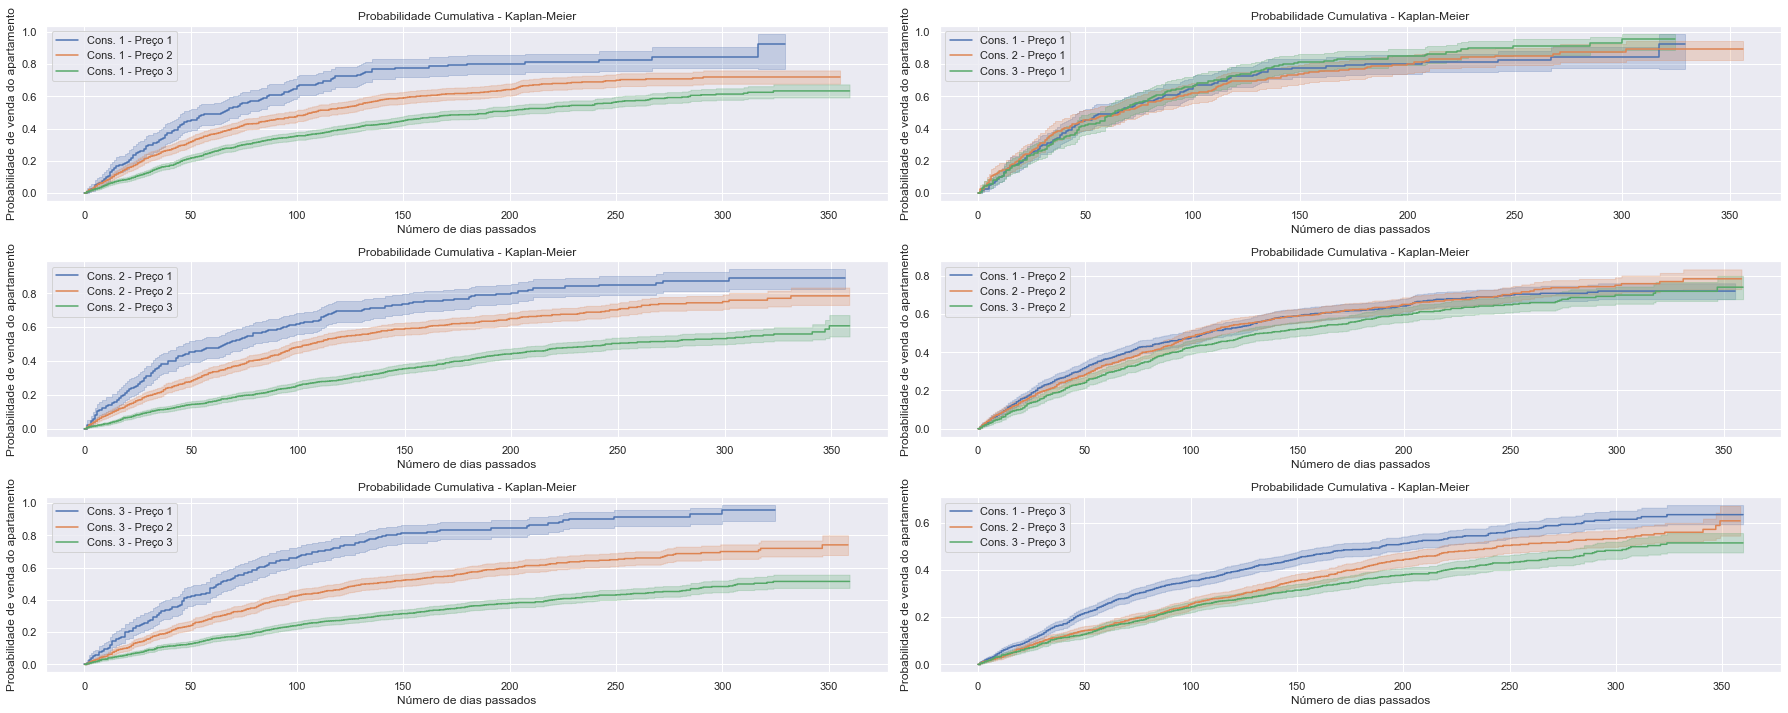

In [43]:
# gráficos kaplan meier com grupos
fig, axes = plt.subplots(3, 2, figsize = (25, 10))
kmf_1.plot_cumulative_density(ax = axes.ravel()[0]);
kmf_2.plot_cumulative_density(ax = axes.ravel()[0]);
kmf_3.plot_cumulative_density(ax = axes.ravel()[0]);
kmf_4.plot_cumulative_density(ax = axes.ravel()[2]);
kmf_5.plot_cumulative_density(ax = axes.ravel()[2]);
kmf_6.plot_cumulative_density(ax = axes.ravel()[2]);
kmf_7.plot_cumulative_density(ax = axes.ravel()[4]);
kmf_8.plot_cumulative_density(ax = axes.ravel()[4]);
kmf_9.plot_cumulative_density(ax = axes.ravel()[4]);

kmf_1.plot_cumulative_density(ax = axes.ravel()[1]);
kmf_4.plot_cumulative_density(ax = axes.ravel()[1]);
kmf_7.plot_cumulative_density(ax = axes.ravel()[1]);
kmf_2.plot_cumulative_density(ax = axes.ravel()[3]);
kmf_5.plot_cumulative_density(ax = axes.ravel()[3]);
kmf_8.plot_cumulative_density(ax = axes.ravel()[3]);
kmf_3.plot_cumulative_density(ax = axes.ravel()[5]);
kmf_6.plot_cumulative_density(ax = axes.ravel()[5]);
kmf_9.plot_cumulative_density(ax = axes.ravel()[5]);

for ax in axes.ravel():
    ax.set_title("Probabilidade Cumulativa - Kaplan-Meier");
    ax.set_xlabel("Número de dias passados");
    ax.set_ylabel("Probabilidade de venda do apartamento");
plt.tight_layout();

## 6.5. Teste Log-Rank<a id='log_rank'></a>

O teste de Log-Rank é utilizado para comparar a distribuição de sobrevivência de grupos.

**Hipótese Nula**: Não há diferença estatística entre os grupos estudados.

Avaliar p-valor, o qual é definido como a probabilidade de obter resultados mais extremos ou iguais aos resultados observados, considerando que a hipótese nula é correta.

### 6.5.1. Teste Log-Rank conservação<a id='log_rank_conservacao'></a>

Como todos os p-valores, tanto para os testes em pares, quanto os testes multivariados, são menores que 0.005 (significativo), pode-se concluir que distribuições de sobrevivência entre níveis de conservação de apartamento são estatisticamente diferentes. Em outras palavras, pode-se dizer que o nível de conservação do apartamento afeta sua liquidez.

In [44]:
# log-rank pairwise conservacao
results = pairwise_logrank_test(df6['time_on_market'],
                                df6['interior_quality'],
                                df6['sold'])
print(f"P-value 1-2: {results.p_value[0]}")
print(f"P-value 1-3: {results.p_value[1]}")
print(f"P-value 2-3: {results.p_value[2]}")

P-value 1-2: 0.000521662081923677
P-value 1-3: 2.6886015281983435e-11
P-value 2-3: 0.001087279801265801


In [45]:
# log-rank multivariate conservacao
results = multivariate_logrank_test(df6['time_on_market'],
                                df6['interior_quality'],
                                df6['sold'])
print(f"P-value 1-2-3: {results.p_value}")

P-value 1-2-3: 1.5371229670492584e-10


### 6.5.2. Teste Log-Rank preço<a id='log_rank_preco'></a>

Verifica-se que o p-value é mínimo, indicando grande significância na rejeição da hipótese nula para diferentes preços.

In [46]:
# log-rank pairwise conservacao
results = pairwise_logrank_test(aux['time_on_market'],
                                aux['categoria_preco'],
                                aux['sold'])
print(f"P-value 1-2: {results.p_value[0]}")
print(f"P-value 1-3: {results.p_value[1]}")
print(f"P-value 2-3: {results.p_value[2]}")

P-value 1-2: 1.7216136833330045e-27
P-value 1-3: 9.414869019305456e-129
P-value 2-3: 5.480596465983666e-60


In [47]:
# log-rank multivariate conservacao
results = multivariate_logrank_test(aux['time_on_market'],
                                aux['categoria_preco'],
                                aux['sold'])
print(f"P-value 1-2-3: {results.p_value}")

P-value 1-2-3: 9.543294008777204e-141


### 6.5.2. Teste Log-Rank conservação e preço<a id='log_rank_conservacao_preco'></a>

Como foi possível avaliar já nos gráficos, para faixas de preços menores (1 e 2), não é possível concluir que há diferença entre as curvas de sobrevivência para diferentes estados de conservação. Para a faixa maior de preço (3), não é possível concluir que há diferença entre os estados de conservação 2 e 3.

In [48]:
# log-rank pairwise conservacao - preco
results = pairwise_logrank_test(aux['time_on_market'],
                                aux['categoria_conservacao_preco'],
                                aux['sold'])
results

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
       test_statistic      p  -log2(p)
11 12           24.59 <0.005     20.43
   13          105.01 <0.005     79.45
   21            0.00   0.99      0.02
   22           27.57 <0.005     22.65
   23          199.10 <0.005    147.77
   31            0.57   0.45      1.15
   32           51.56 <0.005     40.39
   33          240.04 <0.005    177.44
12 13           45.65 <0.005     36.04
   21           26.50 <0.005     21.85
   22            0.01   0.92      0.12
   23          127.24 <0.005     95.62
   31           38.78 <0.005     30.98
   32            7.15   0.01      7.06
   33          178.06 <0.005    132.51
13 21          111.36 <0.005     84.07
   22           46.24 <0.005     36.48
   23           25.21 <0.005     20.89
   31          143.38 <0.005    107.34
   32           13.40 <0.005     11.95
   33           54.95 <0.005     42.88
21 22           28.35 <0.005     23.23
   23          205.04 <0.005    152.08
   31            0.88   0.35      1.52
   32           53.49 <0.005     41.81
   33          253.08 <0.005    186.88
22 23          131.03 <0.005     98.37
   31           44.16 <0.005     34.94
   32            7.14   0.01      7.05
   33          184.90 <0.005    137.48
23 31          264.48 <0.005    195.14
   32           66.28 <0.005     51.18
   33            6.12   0.01      6.23
31 32           75.00 <0.005     57.56
   33          313.33 <0.005    230.49
32 33          105.58 <0.005     79.86

In [49]:
# log-rank multivariate conservacao
results = multivariate_logrank_test(aux['time_on_market'],
                                aux['categoria_conservacao_preco'],
                                aux['sold'])
results

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 8
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         702.85 <0.005    484.20

# 7. Preparação dos dados<a id='preparacao'></a>

In [50]:
df7 = df6.copy()

In [51]:
df7.columns

Index(['rooms', 'garages', 'useful_area', 'latitude', 'longitude', 'value',
       'interior_quality', 'time_on_market', 'sold', 'rooms_garages',
       'lat_long_bins'],
      dtype='object')

## 7.1. Filtragem de Colunas<a id='filtragem_colunas'></a>

Serão excluídas as colunas: rooms, garages, latitude e longitude.

In [52]:
# seleção de colunas
df7 = df7[['useful_area', 'value', 'interior_quality', 'time_on_market', 'sold', 'rooms_garages', 'lat_long_bins']]

## 7.2. Encoding<a id='rescale_encoding'></a>

Como será visto mais para frente, o modelo utilizado não é afetado diretamente por diferentes ranges de features e outliers, então a re-escala não será necessária. Será aplicado o One Hot Encoding para o lat_long_bins.

In [53]:
# one hot encoding lat_long_bins
df7 = pd.get_dummies(df7, columns = ['lat_long_bins'], drop_first = True)

## 7.3. Separação Treino-Validação<a id='treino_validacao'></a>

In [54]:
# definindo X e y
X = df7.drop(columns = ['time_on_market', 'sold'])
y = convert_to_structured(df7['time_on_market'], df7['sold'])

X_train, X_valid, y_train, y_valid = train_test_split(
                 X, y, test_size=0.15, random_state=42)

# 8. Modelagem de Machine Learning<a id='machile_learning'></a>

Para modelar a liquidez de um apartamento, será utilizado o modelo **XGBoost Survival Embeddings**, uma adaptação do modelo XGBoost para análises de sobrevivência. Este pacote busca unir os pontos fortes de modelos implementados de análise de sobrevivência: modelos com propriedades estatísticas fortes (curvas de sobrevivência calibradas), sendo ao mesmo tempo expressivos e computacionalmente eficientes.

Para cada uma das variações do XGBoost Survival Embeddings, será realizado a cross-validation de acordo com o Brier Score, o qual é similar ao Log-Loss, com a diferença de que são consideradas as probabilidades preditas em vez dos labels. Tais resultados serão utilizados como pré-seleção de modelo. A variação com Nearest Neighbors não será considerada por causa do seu custo computacional proporcional ao tamanho do dataset.

In [55]:
df8 = df7.copy()

## 8.1. Teoria XGBoost Survival Embeddings<a id='xgboost'></a>

Fonte: [XGBoost Survival Embeddings](https://towardsdatascience.com/xgbse-improving-xgboost-for-survival-analysis-393d47f1384a)

A implementação de XGBoost em análise de sobrevivência apresenta dois métodos para tal: Cox e Accelerated Failure Time (AFT). Contudo, ainda há três propriedades estatísticas que preocupam sobre sua aplicação:

* Previsão de estimativas diretas, não de curvas  de sobrevivência
* Ausência de estimativa de intervalos de confiança
* Tempos de sobrevivência esperados não-calibrados

Para contornar tais pontos, o modelo de XGBoost é utilizado então como um transformador de feature, utilizando as folhas de cada árvore como features. Utilizando de tal método, adquire-se algumas propriedades convenientes:

1. Variáveis esparsas e alta-dimensionalidade: árvores lidam muito bem com não-linearidades e transformam as features originais em embeddings espaçadas e de alta dimensão, o que auxilia modelos lineares a performarem melhor.

2. Supervisão: árvores também funcionam como filtro de ruídos, realizando seccionamentos apenas em features que possuem poder de predição. Assim, o embedding tem uma dimensão intrínseca menor que os dados originais de entrada.

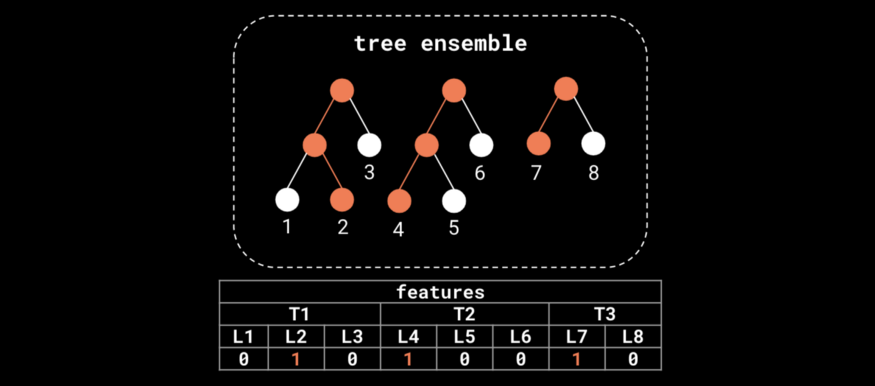

A classe XGBSEDebiasedBCE consiste no treino de conjuntos de regressões logísticas, utilizando os embeddings como inputs, prevendo a sobrevivência para diferentes observações em uma janela discreta de tempo. O uso de regressão logística faz com que as probabilidades sejam calibradas.

A classe XGBSEKaplanNeighbors consiste no uso do modelo de vizinhos próximos juntamente com a distância de hamming para definir elementos similares àqueles nos nós terminais do ensemble.

As classes XGBSEKaplanTree e XGBSEBootstrapEstimator se utilizam de árvores simples para gerar estimativas. É a implementação mais eficiente, embora seu poder preditivo seja baixo, podendo utilizar o estimador com bootstrap para criar uma floresta.

## 8.2. Parâmetros<a id='parametros'></a>

Para cada modelo testado, serão definidos alguns parâmetros padrões.

In [56]:
# parâmetros pré-selecionados
PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

## 8.3. XGBoost + Regressão Logística - Cross Validation<a id='xgb_logistic_cv'></a>

In [57]:
# instanciando modelo
xgbse_logistic = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)

results = cross_val_score(xgbse_logistic, X, y, cv = 5, scoring=make_scorer(approx_brier_score))

print(f"XGBoost + Regressão Logistica - CV Brian Score: {results.mean()}")

XGBoost + Regressão Logistica - CV Brian Score: 0.1779770441099391


## 8.4. XGBoost + Árvore Única - Cross Validation<a id='xgb_arvore_cv'></a>

In [58]:
# instanciando modelo
xgbse_tree = XGBSEKaplanTree(PARAMS_TREE)

results = cross_val_score(xgbse_tree, X, y, cv = 5, scoring=make_scorer(approx_brier_score))

print(f"XGBoost + Árvore Única - CV Brian Score: {results.mean()}")

XGBoost + Árvore Única - CV Brian Score: 0.18396909985853685


## 8.5. XGBoost + Floresta - Cross Validation<a id='xgb_floresta_cv'></a>

In [59]:
# instanciando modelo
xgbse_forest = XGBSEBootstrapEstimator(xgbse_tree, n_estimators=20)

results = cross_val_score(xgbse_forest, X, y, cv = 5, scoring=make_scorer(approx_brier_score))

print(f"XGBoost + Floresta - CV Brian Score: {results.mean()}")

XGBoost + Floresta - CV Brian Score: 0.18894063604590366


Devido a rapidez do algoritmo e por possuir resultados próximos ao melhor (Regressão Logística), será utilizado o algoritmo de XGBoost + Floresta, o qual aplica estimadores de Kaplan-Meier para cada folha da árvore. Este foi escolhido em detrimento do modelo com árvore única pois, embora o modelo com árvore única retorne um score melhor, sua capacidade de generalização é limitada e este corre o risco de overfittar o dataset.

# 9. Tunning de Hiperparâmetros<a id='tunning'></a>

Realizando o Tunning de apenas max_depth, min_child_weight e n_estimators, seleciona-se os valores:

* max_depth = 20
* min_child_weight = 40
* n_estimators = 20

In [60]:
# definindo o parametro a ser testado
max_depths = [10, 20, 30, 40, 50, 60, 80, 100]
min_child_weights = [10, 20, 30, 40, 50, 60, 80, 100]
n_estimators = [10, 20, 30, 50, 80, 100]

xgbse_tree = XGBSEKaplanTree()
metrics = pd.DataFrame(columns = ['max_depth', 'min_child_weight', 'n_estimators', 'score'])
md = []
mcw = []
e = []
s = []

for max_depth in tqdm(max_depths):
    for min_child_weight in min_child_weights:
        for estimators in n_estimators:
    
            PARAMS_TREE = {
            'objective': 'survival:cox',
            'eval_metric': 'cox-nloglik',
            'max_depth': max_depth, 
            'booster':'dart', 
            'subsample': 1.0,
            'min_child_weight': min_child_weight, 
            'colsample_bynode': 1.0
        }

            xgbse_tree = XGBSEKaplanTree(PARAMS_TREE)
            xgbse_forest = XGBSEBootstrapEstimator(xgbse_tree, n_estimators=estimators)

            results = cross_val_score(xgbse_tree, X, y, cv = 5, scoring=make_scorer(approx_brier_score))

            md.append(max_depth)
            e.append(estimators)
            mcw.append(min_child_weight)
            s.append(results.mean())

metrics['max_depth'] = md
metrics['min_child_weight'] = mcw
metrics['n_estimators'] = e
metrics['score'] = s
    
metrics.sort_values(by = 'score').head(20)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [07:50<00:00, 58.77s/it]


,max_depth,min_child_weight,n_estimators,score
359,100,40,100,0.183545
210,50,40,10,0.183545
211,50,40,20,0.183545
212,50,40,30,0.183545
213,50,40,50,0.183545
214,50,40,80,0.183545
306,80,40,10,0.183545
215,50,40,100,0.183545
71,20,40,100,0.183545
70,20,40,80,0.183545


## 9.1. Modelo Final e Export<a id='modelo_final'></a>

In [61]:
# parâmetros
PARAMS_TREE = {
        'objective': 'survival:cox',
        'eval_metric': 'cox-nloglik',
        'max_depth': 20, 
        'booster':'dart', 
        'subsample': 1.0,
        'min_child_weight': 40, 
        'colsample_bynode': 1.0
    }

TIME_BINS = np.arange(0, 360, 5)

# fitting de modelo de árvore final
xgbse_tree = XGBSEKaplanTree(PARAMS_TREE)
# xgbse_logistic = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)
xgbse_model = XGBSEBootstrapEstimator(xgbse_tree, n_estimators=20)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

XGBSEBootstrapEstimator(base_estimator=XGBSEKaplanTree(xgb_params={'booster': 'dart',
                                                                   'colsample_bynode': 1.0,
                                                                   'eval_metric': 'cox-nloglik',
                                                                   'max_depth': 20,
                                                                   'min_child_weight': 40,
                                                                   'objective': 'survival:cox',
                                                                   'subsample': 1.0}),
                        n_estimators=20)

In [62]:
# guardar nome de variáveis
xgbse_model.feature_names = list(X_train.columns.values)

In [63]:
# export
with open("./model/portfolio_2.pkl", "wb") as file:
    pickle.dump(xgbse_model, file)

# 10. Análise Prescritiva<a id='prescritiva_negocio'></a>

Após elaboração do modelo, este será utilizado para estimar e analisar resultados a partir da modificação de valores de features.

Verifica-se que o C-index, uma métrica equivalente ao ROC-AUC para análises de sobrevivência, chegou a um patamar de 0.681, e o Brier-Score, equivalente ao Log-Loss só que considerando probabilidades retornadas. Verifica-se que não houve tendência de overfitting.

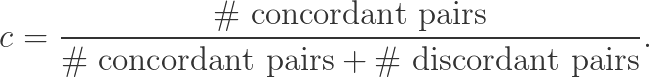

In [64]:
# predicting and evaluating
preds = xgbse_model.predict(X_valid)
c_ind = concordance_index(y_valid, preds) # por média
brier = approx_brier_score(y_valid, preds)
avg_probs = preds[[30, 90, 150]].mean().values.round(4).tolist()

print(f"C-index: {c_ind:.3f}")
print(f"Brier-Score: {brier:.3f}")

C-index: 0.689
Brier-Score: 0.172


## 10.1. Comparação curvas de sobrevivência<a id='comparacao_sobrevivencia'></a>

Aqui será feita uma comparação de curvas de sobrevivência entre apartamentos que foram vendidos ou não, de modo a validar o modelo.

Pontos observados:

* **Maiores probabilidades de venda por janela de tempo para os apartamentos de fato vendidos**
* **Maior probabilidade de tempo médio total para os apartamentos vendidos**
* **A média de probabilidade de venda dos apartamentos não vendidos mal chega a 60%**
* **Probabilidade média de venda para apartamentos vendidos: 54.3%**
* **Probabilidade média de venda para apartamentos não vendidos: 39.5%**

In [65]:
# concatenando X_valid e y_valid
df_valid = pd.concat([X_valid.reset_index(drop = True), 
                      pd.DataFrame(y_valid)], axis = 1) \
             .rename(columns = {'c1' : 'sold',
                                'c2' : 'time_on_market'})

In [66]:
# separando registros que foram vendidos e não vendidos
vendidos = df_valid.loc[df_valid['sold'] == True]
nao_vendidos = df_valid.loc[df_valid['sold'] == False]

# media de dias no mercado
vendidos_market = vendidos['time_on_market'].mean()
nao_vendidos_market = nao_vendidos['time_on_market'].mean()

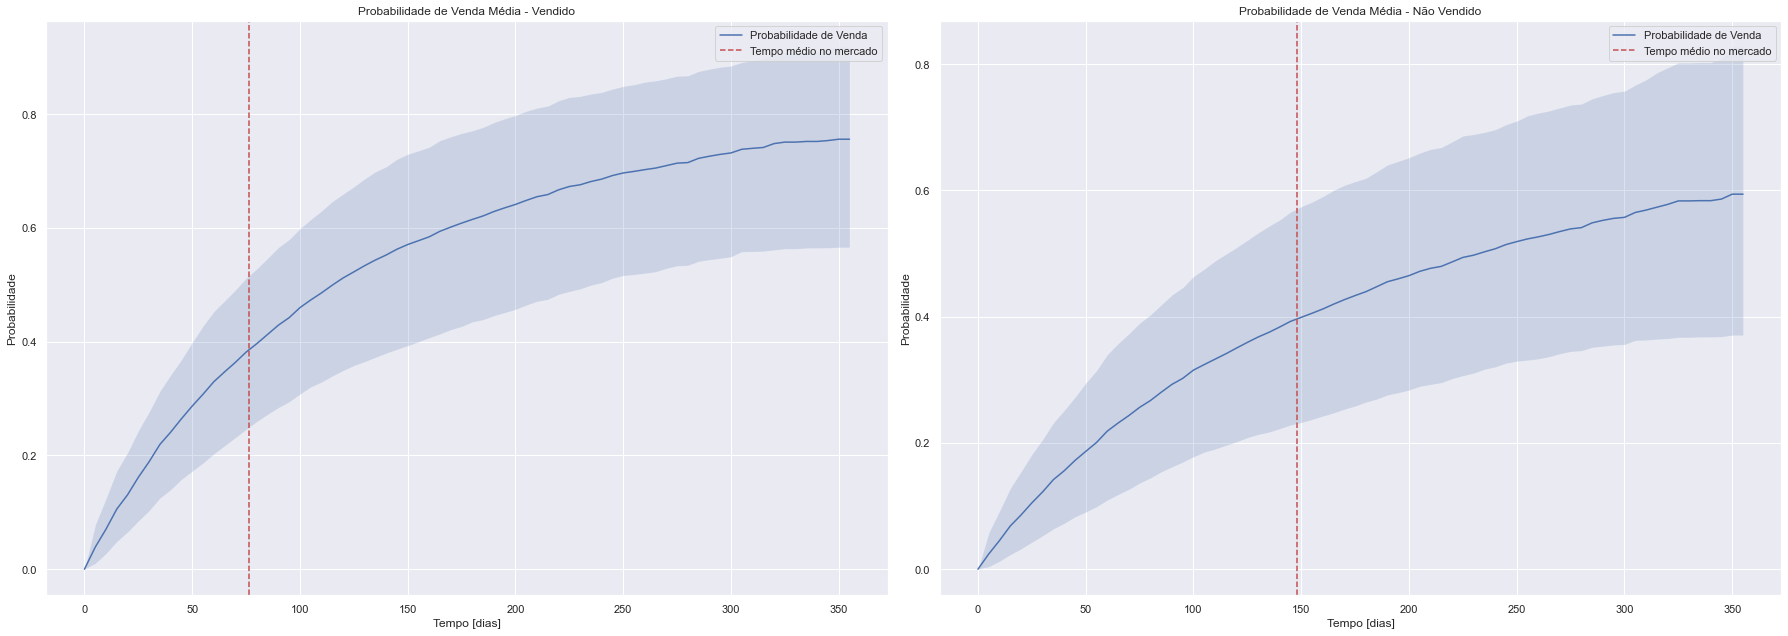

In [67]:
fig, ax = plt.subplots(1,2)

# estimando probabilidades
mean0, upper_ci0, lower_ci0 = xgbse_model.predict(vendidos.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean1, upper_ci1, lower_ci1 = xgbse_model.predict(nao_vendidos.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)

# plot de CIs
plot_ci(1 - mean0, 1 - upper_ci0, 1 - lower_ci0, ax = ax.ravel()[0], title = 'Probabilidade de Venda Média - Vendido', vline = vendidos_market)
plot_ci(1 - mean1, 1 - upper_ci1, 1 - lower_ci1, ax = ax.ravel()[1], title = 'Probabilidade de Venda Média - Não Vendido', vline = nao_vendidos_market)

In [68]:
# probabilidade média de venda entre vendidos e não vendidos para toda a janela de tempo
df = show_mean_risk(mean0, mean1, names = ['Vendidos', 'Não vendidos'])
df

,Descrição,Probabilidade Média para toda Janela
0,Vendidos,0.543
1,Não vendidos,0.395


## 10.2. Influência do preço na liquidez<a id='influencia_preco_liquidez'></a>

Alterando o preço do apartamento para cima ou para baixo, como a liquidez do apartamento seria afetada? Esta análise é importante para poder definir o preço de venda de apartamentos. Os preços serão aumentados e diminuídos em 10%, verificando sua influência a partir da capacidade de generalização do modelo treinado.

Pontos obervados:

* **Independente se foi vendido ou não, o aumento de preço faz com que a liquidez do apartamento diminua**
* **Vendidos - Aumento de 10% no preço: queda de 5.6% pontos percentuais na probabilidade de venda**
* **Vendidos - Diminuição de 10% no preço: aumento de 5.7% pontos percentuais na probabilidade de venda**
* **Não Vendidos - Aumento de 10% no preço: queda de 6.1% pontos percentuais na probabilidade de venda**
* **Não Vendidos - Diminuição de 10% no preço: aumento de 6.4% pontos percentuais na probabilidade de venda**

In [69]:
# separando registros que foram vendidos e não vendidos
vendidos = df_valid.loc[df_valid['sold'] == True]
nao_vendidos = df_valid.loc[df_valid['sold'] == False]

# aumentando preço em 10%
vendidos_mais_10 = vendidos.copy()
vendidos_mais_10['value'] = vendidos_mais_10['value'] * 1.1
nao_vendidos_mais_10 = nao_vendidos.copy()
nao_vendidos_mais_10['value'] = nao_vendidos_mais_10['value'] * 1.1

# diminuindo preço em 10%
vendidos_menos_10 = vendidos.copy()
vendidos_menos_10['value'] = vendidos_menos_10['value'] * 0.9
nao_vendidos_menos_10 = nao_vendidos.copy()
nao_vendidos_menos_10['value'] = nao_vendidos_menos_10['value'] * 0.9

# media de dias no mercado
vendidos_market = vendidos['time_on_market'].mean()
nao_vendidos_market = nao_vendidos['time_on_market'].mean()

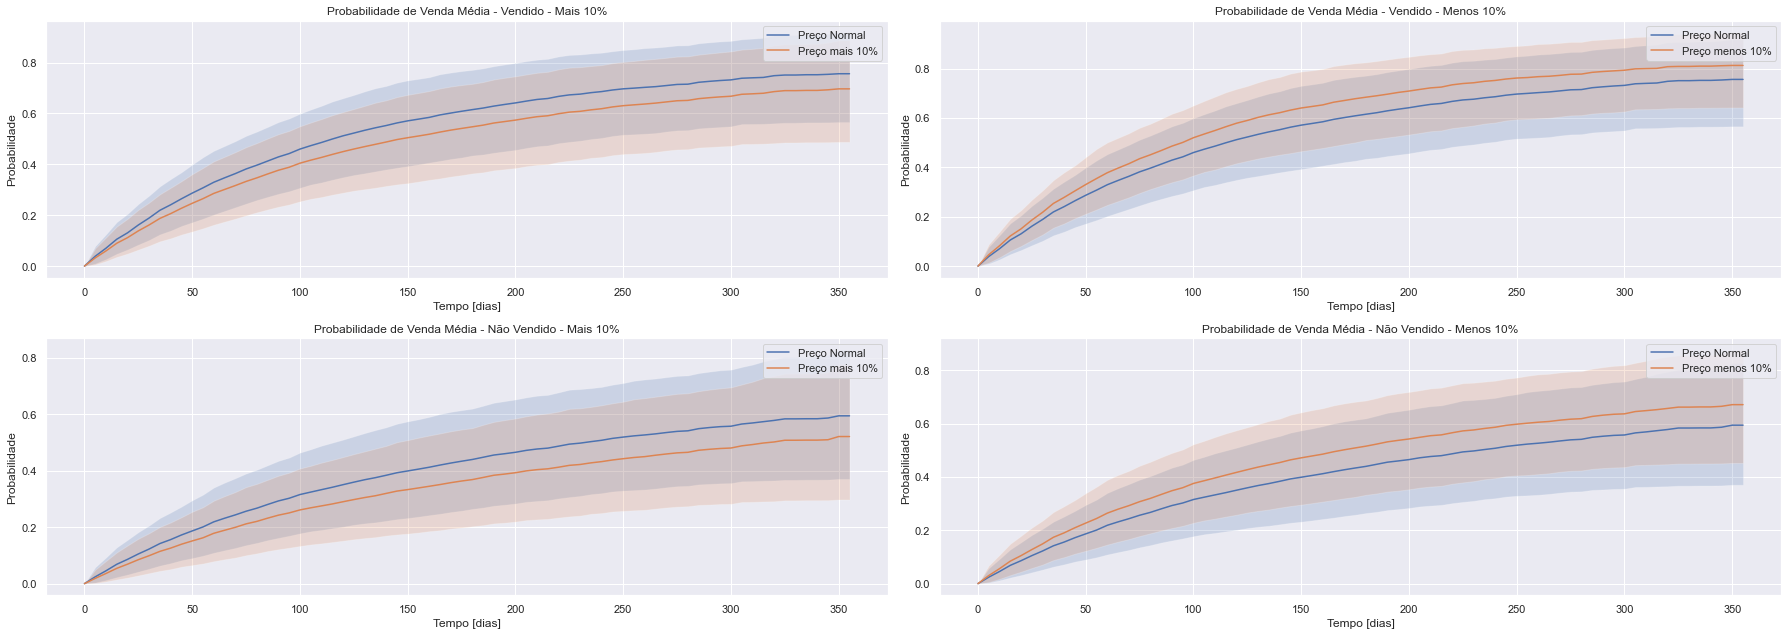

In [70]:
fig, ax = plt.subplots(2,2)

# estimando probabilidades
mean0, upper_ci0, lower_ci0 = xgbse_model.predict(vendidos.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean1, upper_ci1, lower_ci1 = xgbse_model.predict(vendidos_mais_10.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean2, upper_ci2, lower_ci2 = xgbse_model.predict(vendidos_menos_10.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean3, upper_ci3, lower_ci3 = xgbse_model.predict(nao_vendidos.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean4, upper_ci4, lower_ci4 = xgbse_model.predict(nao_vendidos_mais_10.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean5, upper_ci5, lower_ci5 = xgbse_model.predict(nao_vendidos_menos_10.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)

# plot de CIs
plot_ci(1 - mean0, 1 - upper_ci0, 1 - lower_ci0, ax = ax.ravel()[0], title = 'Probabilidade de Venda Média - Vendido', label = "Preço Normal");
plot_ci(1 - mean1, 1 - upper_ci1, 1 - lower_ci1, ax = ax.ravel()[0], title = 'Probabilidade de Venda Média - Vendido - Mais 10%', label = "Preço mais 10%");

plot_ci(1 - mean0, 1 - upper_ci0, 1 - lower_ci0, ax = ax.ravel()[1], title = 'Probabilidade de Venda Média - Vendido', label = "Preço Normal");
plot_ci(1 - mean2, 1 - upper_ci2, 1 - lower_ci2, ax = ax.ravel()[1], title = 'Probabilidade de Venda Média - Vendido - Menos 10%', label = "Preço menos 10%");

plot_ci(1 - mean3, 1 - upper_ci3, 1 - lower_ci3, ax = ax.ravel()[2], title = 'Probabilidade de Venda Média - Não Vendido', label = "Preço Normal");
plot_ci(1 - mean4, 1 - upper_ci4, 1 - lower_ci4, ax = ax.ravel()[2], title = 'Probabilidade de Venda Média - Não Vendido - Mais 10%', label = "Preço mais 10%");

plot_ci(1 - mean3, 1 - upper_ci3, 1 - lower_ci3, ax = ax.ravel()[3], title = 'Probabilidade de Venda Média - Não Vendido', label = "Preço Normal");
plot_ci(1 - mean5, 1 - upper_ci5, 1 - lower_ci5, ax = ax.ravel()[3], title = 'Probabilidade de Venda Média - Não Vendido - Menos 10%', label = "Preço menos 10%");

In [71]:
# probabilidade média de venda entre vendidos e não vendidos para toda a janela de tempo
df = show_mean_risk(mean0, mean1, mean2, mean3, mean4, mean5, names = ['Vendidos - Normal', 'Vendidos - Mais 10%', 'Vendidos - Menos 10%',
                                                                      'Não Vendidos - Normal', 'Não Vendidos - Mais 10%', 'Não Vendidos - Menos 10%'])
df

,Descrição,Probabilidade Média para toda Janela
0,Vendidos - Normal,0.543
1,Vendidos - Mais 10%,0.487
2,Vendidos - Menos 10%,0.599
3,Não Vendidos - Normal,0.395
4,Não Vendidos - Mais 10%,0.335
5,Não Vendidos - Menos 10%,0.46


## 10.3. Influência do estado de conservação<a id='influencia_conservacao'></a>

Agora, será feito o mesmo processo de comparação de curvas, porém, alterando o estado de conservação para aqueles apartamentos com estado 1 ou 2 e verificando como isto impacta nas probabilidades retornadas pelo modelo, para apartamentos vendidos e não vendidos. Além disso, será avaliado também a diferença de curvas de probabilidade entre apartamentos reformados e apartamentos já em bom estado, para verificar se há diferença entre essas duas classes.

### 10.3.1. Reformando apartamentos em estado de conservação 1 e 2<a id='reforma_1_2'></a>

Pontos observados:

* **De forma geral, a reforma do apartamento diminui a liquidez do apartamento**
* **Reforma em vendidos: queda de 3.1% pontos percentuais na probabilidade de venda**
* **Reforma em não vendidos: queda de 4.3% pontos percentuais na probabilidade de venda**

In [72]:
# separando registros que foram vendidos e não vendidos e por estado de conservacao, realizando a mudanca de qualidade 1 e 2 para 3
vendidos_3 = vendidos.loc[vendidos['interior_quality'].isin([1, 2])]
vendidos_3['interior_quality'] = 3
vendidos_12 = vendidos.loc[vendidos['interior_quality'].isin([1, 2])]

nao_vendidos_3 = nao_vendidos.loc[nao_vendidos['interior_quality'].isin([1, 2])]
nao_vendidos_3['interior_quality'] = 3
nao_vendidos_12 = nao_vendidos.loc[nao_vendidos['interior_quality'].isin([1, 2])]

# media de dias no mercado
vendidos_market = vendidos_3['time_on_market'].mean()
nao_vendidos_market = nao_vendidos['time_on_market'].mean()

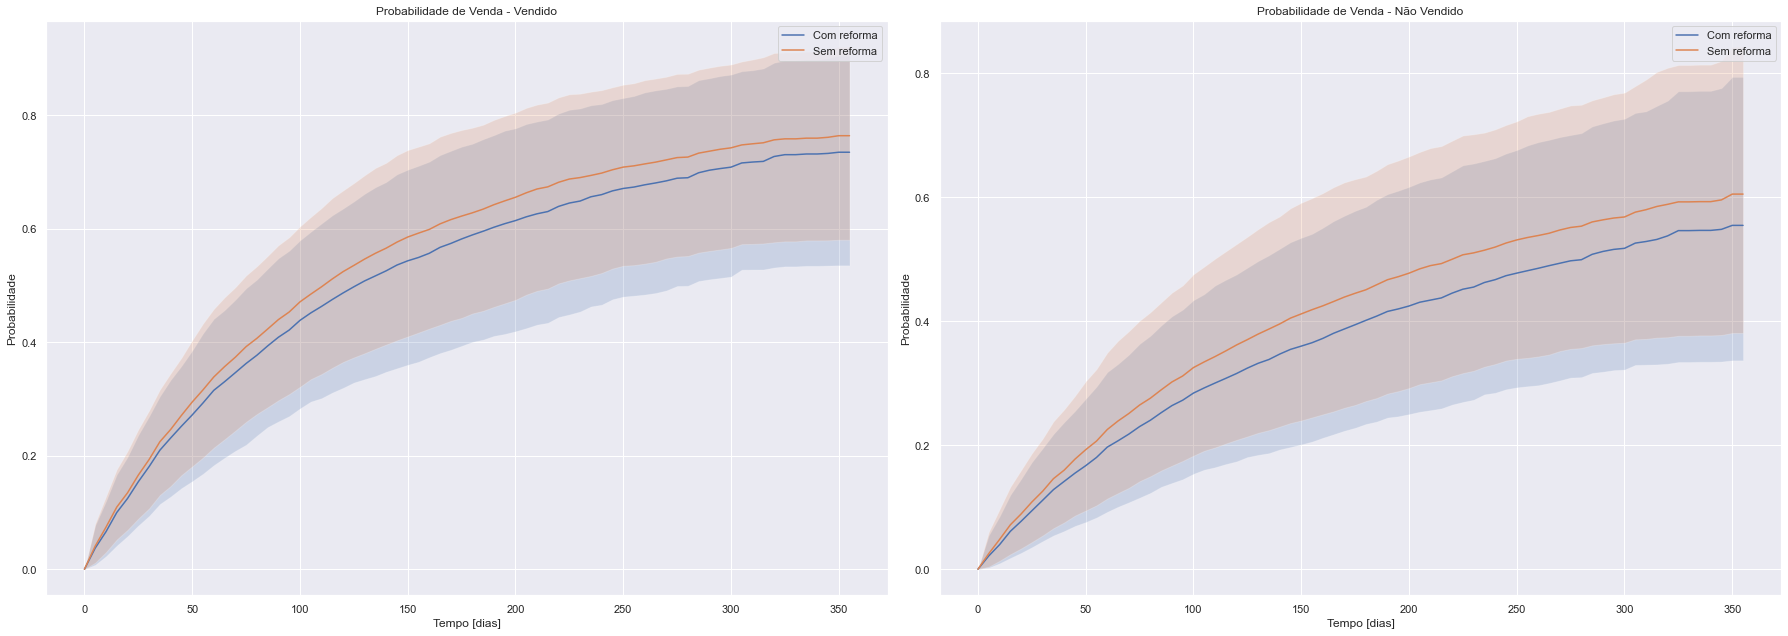

In [73]:
fig, ax = plt.subplots(1,2)

# estimando probabilidades
mean0, upper_ci0, lower_ci0 = xgbse_model.predict(vendidos_3.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean1, upper_ci1, lower_ci1 = xgbse_model.predict(vendidos_12.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean2, upper_ci2, lower_ci2 = xgbse_model.predict(nao_vendidos_3.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean3, upper_ci3, lower_ci3 = xgbse_model.predict(nao_vendidos_12.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)

# plot de CIs
plot_ci(1 - mean0, 1 - upper_ci0, 1 - lower_ci0, ax = ax.ravel()[0], title = 'Probabilidade de Venda - Vendido', label = "Com reforma")
plot_ci(1 - mean1, 1 - upper_ci1, 1 - lower_ci1, ax = ax.ravel()[0], title = 'Probabilidade de Venda - Vendido', label = "Sem reforma")
plot_ci(1 - mean2, 1 - upper_ci2, 1 - lower_ci2, ax = ax.ravel()[1], title = 'Probabilidade de Venda - Não Vendido', label = "Com reforma")
plot_ci(1 - mean3, 1 - upper_ci3, 1 - lower_ci3, ax = ax.ravel()[1], title = 'Probabilidade de Venda - Não Vendido', label = "Sem reforma")

In [74]:
# probabilidade média de venda entre vendidos e não vendidos para toda a janela de tempo
df = show_mean_risk(mean0, mean1, mean2, mean3, mean4, mean5, names = ['Vendidos - Com reforma', 'Vendidos - Sem reforma', 
                                                                       'Não Vendidos - Com reforma', 'Não Vendidos - Sem reforma'])
df

,Descrição,Probabilidade Média para toda Janela
0,Vendidos - Com reforma,0.521
1,Vendidos - Sem reforma,0.553
2,Não Vendidos - Com reforma,0.362
3,Não Vendidos - Sem reforma,0.405


### 10.3.2. Liquidez entre apartamentos reformados e já em estado de conservação 3<a id='reformado_3'></a>

Pontos observados:

* **De forma geral, reformando os apartamentos torna a liquidez deles equiparável a apartamentos bem conservados**
* **Mostra congruência por parte do modelo em relação a influência de variáveis.**

In [75]:
# separando registros que foram vendidos e não vendidos e por estado de conservacao, realizando a mudanca de qualidade 1 e 2 para 3
vendidos_reformados = vendidos.loc[vendidos['interior_quality'].isin([1, 2])]
vendidos_reformados['interior_quality'] = 3
vendidos_conservados = vendidos.loc[vendidos['interior_quality'] == 3]

nao_vendidos_reformados = nao_vendidos.loc[nao_vendidos['interior_quality'].isin([1, 2])]
nao_vendidos_reformados['interior_quality'] = 3
nao_vendidos_conservados = nao_vendidos.loc[nao_vendidos['interior_quality'] == 3]

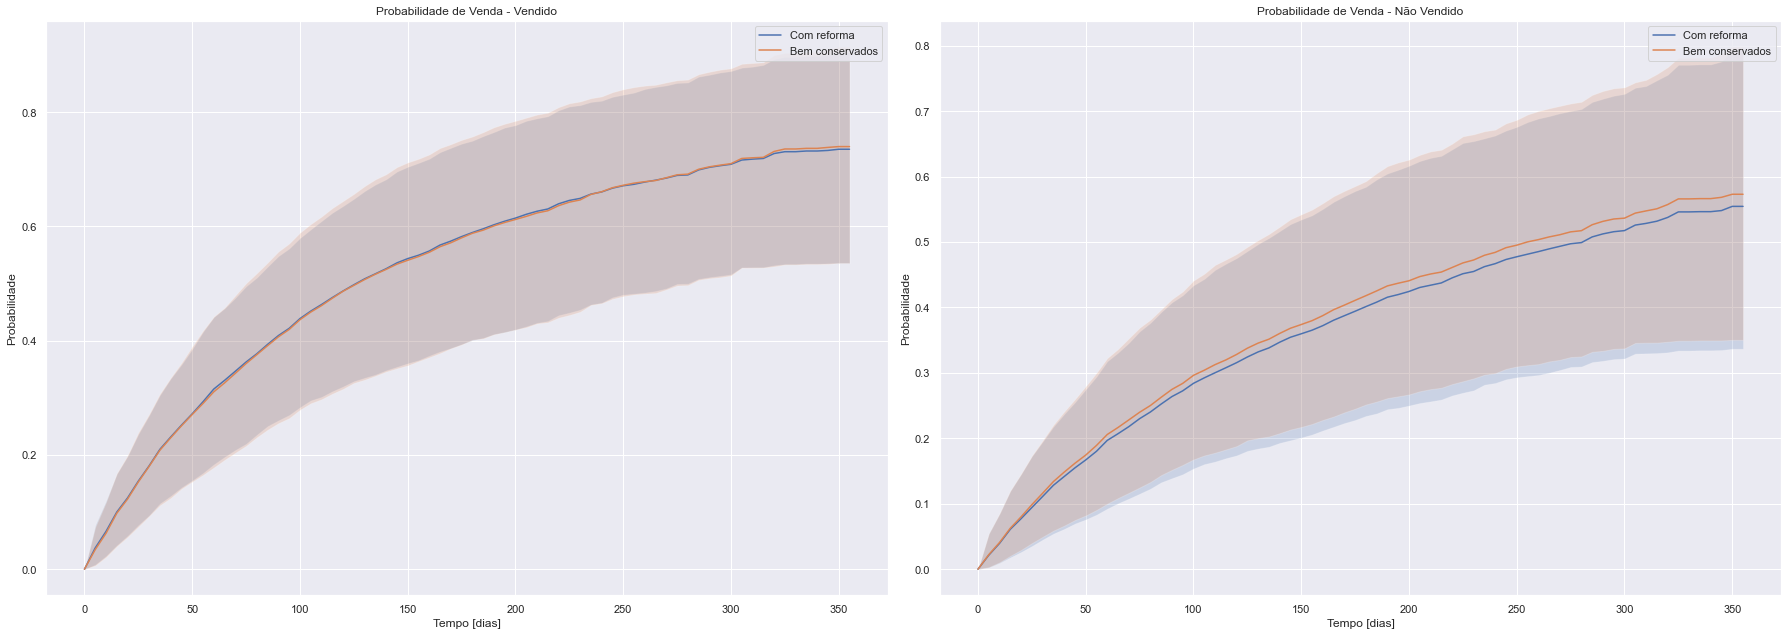

In [76]:
fig, ax = plt.subplots(1,2)

# estimando probabilidades
mean0, upper_ci0, lower_ci0 = xgbse_model.predict(vendidos_reformados.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean1, upper_ci1, lower_ci1 = xgbse_model.predict(vendidos_conservados.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean2, upper_ci2, lower_ci2 = xgbse_model.predict(nao_vendidos_reformados.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)
mean3, upper_ci3, lower_ci3 = xgbse_model.predict(nao_vendidos_conservados.drop(columns = ['sold', 'time_on_market']), return_ci=True, ci_width=0.95)

# plot de CIs
plot_ci(1 - mean0, 1 - upper_ci0, 1 - lower_ci0, ax = ax.ravel()[0], title = 'Probabilidade de Venda - Vendido', label = "Com reforma")
plot_ci(1 - mean1, 1 - upper_ci1, 1 - lower_ci1, ax = ax.ravel()[0], title = 'Probabilidade de Venda - Vendido', label = "Bem conservados")
plot_ci(1 - mean2, 1 - upper_ci2, 1 - lower_ci2, ax = ax.ravel()[1], title = 'Probabilidade de Venda - Não Vendido', label = "Com reforma")
plot_ci(1 - mean3, 1 - upper_ci3, 1 - lower_ci3, ax = ax.ravel()[1], title = 'Probabilidade de Venda - Não Vendido', label = "Bem conservados")

In [77]:
# probabilidade média de venda entre vendidos e não vendidos para toda a janela de tempo
df = show_mean_risk(mean0, mean1, mean2, mean3, names = ['Vendidos - Com reforma', 'Vendidos - Bem conservados', 
                                                        'Não Vendidos - Com reforma', 'Não Vendidos - Bem conservados'])
df

,Descrição,Probabilidade Média para toda Janela
0,Vendidos - Com reforma,0.521
1,Vendidos - Bem conservados,0.521
2,Não Vendidos - Com reforma,0.362
3,Não Vendidos - Bem conservados,0.376


# 11. Seleção de apartamentos e Performance de Negócio<a id='selecao_apartamentos'></a>

Tem-se as seguintes opções:

1. Comprar apartamentos com estado de conservação 1 ou 2 e revender
2. Comprar apartamentos com estado de conservação 1 ou 2, reformar e revender
3. Comprar apartamentos com estado de conservação 3 e revender

Dado que, tanto a reforma quanto o aumento de preço reduz a liquidez, e aqui buscamos maximizar o lucro por dia no mercado, aparentemente a segunda opção será a pior. Contudo, todas serão consideradas, sendo que o lucro por preço no mercado será calculado da seguinte forma:

1. Preços serão variados com um aumento de 30 a 100% em relação ao preço de compra
2. Se o estado de conservação do apartamento for abaixo de 3, será considerado uma opção de reforma do apartamento
3. Para cada combinação, o modelo estimará as curvas de probabilidade de sobrevivência, obtendo por consequência, a probabilidade de venda
4. Na avaliação do modelo, a média de probabilidade para os vendidos é de 0.543, assim, a data estimada para venda do apartamento será quando esta probabilidade chegar a 55%
5. Com o preço e data estimados, calcula-se o lucro por dia no mercado por investimento e seleciona-se os melhores, dentro do orçamento disponível.

É necessário, então, obter os apartamentos com o maior coeficiente abaixo, respeitando o limite de orçamento:

$\Large L = \frac{preço\_venda - preço\_compra}{dias\_no\_mercado * preço\_compra}$

In [4]:
# carregando base
apartments_raw = pd.read_csv('./data/target_apartments.csv')
apartments_raw.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality
0,2.00,1.00,57,-23.61,-46.63,454377,2
1,3.00,2.00,120,-23.56,-46.66,1500960,1
2,2.00,2.00,80,-23.56,-46.70,1045980,3
3,3.00,4.00,500,-23.51,-46.65,3707770,3
4,3.00,2.00,122,-23.52,-46.72,1007670,2


In [5]:
# carregando modelo
with open("./model/portfolio_2.pkl", "rb") as file:
    xgbse_model = pickle.load(file)

In [6]:
# checando por valores NaN
apartments_raw.isna().sum()

rooms               0
garages             0
useful_area         0
latitude            0
longitude           0
value               0
interior_quality    0
dtype: int64

In [7]:
apartments = apartments_raw.copy()

## 11.1. Pré-processamento da base de apartamentos<a id='processmento_target'></a>

In [8]:
# lendo arquivos numpy com bins
latitude_bins = pd.IntervalIndex(np.load('./parameters/lat_bins.npy', allow_pickle=True))
longitude_bins = pd.IntervalIndex(np.load('./parameters/long_bins.npy', allow_pickle=True))

# transformando latitude e longitude em bins
apartments['latitude_bins'] = pd.cut(apartments['latitude'], bins = latitude_bins).astype(str)
apartments['longitude_bins'] = pd.cut(apartments['longitude'], bins = longitude_bins).astype(str)

# map de latitude e longitude em labels
map_lat = {}
map_long = {}

for index, item in enumerate(latitude_bins.sort_values().astype(str)):
    map_lat[item] = str(index)
    
for index, item in enumerate(longitude_bins.sort_values().astype(str)):
    map_long[item] = str(index)
    
apartments['latitude_bins'] = apartments['latitude_bins'].map(map_lat)
apartments['longitude_bins'] = apartments['longitude_bins'].map(map_long)

# criando features lat_long_bins e rooms garages
apartments['lat_long_bins'] = apartments['latitude_bins'] + apartments['longitude_bins']
apartments['rooms_garages'] = apartments['rooms'] + apartments['garages']

In [9]:
# seleção de colunas
apartments = apartments[['useful_area', 'value', 'interior_quality', 'rooms_garages', 'lat_long_bins']]

# one hot encoding em lat_long_bins
apartments = pd.get_dummies(apartments, columns = ['lat_long_bins'], drop_first = True)

# colunas originais
original_columns = apartments.columns

## 11.2. Previsão do Modelo para combinações de cenários<a id='previsao_combinacao'></a>

In [10]:
# predict 30% - 100% sem reforma
apartments = predict_scenario(apartments, 
                              xgbse_model, 
                              [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2],
                              renovate = False)

# predict 30% - 100% com reforma
apartments = predict_scenario(apartments, 
                              xgbse_model, 
                              [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2],
                              renovate = True)

30% sem reforma
40% sem reforma
50% sem reforma
60% sem reforma
70% sem reforma
80% sem reforma
90% sem reforma
100% sem reforma
30% com reforma
40% com reforma
50% com reforma
60% com reforma
70% com reforma
80% com reforma
90% com reforma
100% com reforma


In [11]:
# --------- obtendo maior taxa de lucro / (dia * investimento) ---------------#
columns_lucro = [column for column in apartments.columns if column.startswith('LUCRO_DIA_INVEST')]

# coeficiente de lucro / dia, investimento para o melhor cenario 
apartments['better_scenario_coeff'] = apartments[columns_lucro].max(axis = 1)

# melhor cenário de aumento de preço + reforma ou não
apartments['better_scenario'] = apartments[columns_lucro].idxmax(axis = 1)

# observacao da sugestao (com ou sem reforma)
apartments['obs'] = apartments['better_scenario'].str[-11:]

# colunas de melhor aumento de preço
apartments['better_raise'] = 'value_' + apartments['better_scenario'].str.findall('\d+%').apply(pd.Series)

# melhor aumento de preço
apartments['sale_price'] = apartments.loc[~apartments['better_raise'].isna()].apply(lambda x : x[x['better_raise']], axis = 1)

In [12]:
# selecionando colunas pertinentes para sugestao de compra
apartments = apartments[['better_scenario', 'better_raise', 'sale_price', 'better_scenario_coeff', 'obs', 'value']]

# ordenacao por melhor coeficiente de lucro
budget = 150000000
sorted_apartments = apartments.sort_values(by = 'better_scenario_coeff', ascending = False).reset_index()
invested = 0
buy_apartments = pd.DataFrame(columns = sorted_apartments.columns)

for idx, row in sorted_apartments.iterrows():
    if invested + row.value < budget:
        buy_apartments = buy_apartments.append(row)
        invested += row.value
        
buy_apartments

,index,better_scenario,better_raise,sale_price,better_scenario_coeff,obs,value
0,3535,LUCRO_DIA_INVEST_mais_100%_sem_reforma,value_100%,"321,512.00",0.02,sem_reforma,160756
1,8201,LUCRO_DIA_INVEST_mais_100%_sem_reforma,value_100%,"392,060.00",0.01,sem_reforma,196030
2,7784,LUCRO_DIA_INVEST_mais_100%_sem_reforma,value_100%,"380,502.00",0.01,sem_reforma,190251
3,17,LUCRO_DIA_INVEST_mais_90%_sem_reforma,value_90%,"418,345.80",0.01,sem_reforma,220182
4,849,LUCRO_DIA_INVEST_mais_90%_sem_reforma,value_90%,"409,860.40",0.01,sem_reforma,215716
...,...,...,...,...,...,...,...
314,6600,LUCRO_DIA_INVEST_mais_30%_sem_reforma,value_30%,"493,134.20",0.01,sem_reforma,379334
315,968,LUCRO_DIA_INVEST_mais_50%_sem_reforma,value_50%,"600,081.00",0.01,sem_reforma,400054
316,2124,LUCRO_DIA_INVEST_mais_90%_sem_reforma,value_90%,"1,911,818.00",0.01,sem_reforma,1006220
317,571,LUCRO_DIA_INVEST_mais_60%_sem_reforma,value_60%,"481,579.20",0.01,sem_reforma,300987


In [13]:
# merge para trazer informações finais
final_apartments_list = buy_apartments[['index', 'sale_price', 'obs']].merge(apartments_raw, left_on = 'index', right_index = True)
final_apartments_list

,index,sale_price,obs,rooms,garages,useful_area,latitude,longitude,value,interior_quality
0,3535,"321,512.00",sem_reforma,1.00,1.00,40,-23.58,-46.61,160756,1
1,8201,"392,060.00",sem_reforma,1.00,1.00,30,-23.58,-46.64,196030,3
2,7784,"380,502.00",sem_reforma,1.00,1.00,34,-23.62,-46.73,190251,2
3,17,"418,345.80",sem_reforma,2.00,1.00,45,-23.64,-46.60,220182,2
4,849,"409,860.40",sem_reforma,1.00,1.00,29,-23.55,-46.57,215716,3
...,...,...,...,...,...,...,...,...,...,...
314,6600,"493,134.20",sem_reforma,3.00,1.00,67,-23.64,-46.66,379334,1
315,968,"600,081.00",sem_reforma,2.00,1.00,60,-23.50,-46.62,400054,2
316,2124,"1,911,818.00",sem_reforma,4.00,2.00,205,-23.60,-46.72,1006220,2
317,571,"481,579.20",sem_reforma,2.00,1.00,45,-23.57,-46.59,300987,1


In [14]:
Markdown("# Orçamento: R$ 150.000.000,00")

# Orçamento: R$ 150.000.000,00

In [15]:
total_gasto = final_apartments_list['value'].sum()
Markdown("# Total gasto: R$ {:,}".format(total_gasto).replace(',', '.') + ",00")

# Total gasto: R$ 149.813.331,00

In [16]:
total_pos_vendas = int(final_apartments_list['sale_price'].sum())
Markdown("# Total estimado pós-vendas: R$ {:,}".format(total_pos_vendas).replace(',', '.') + ",00")

# Total estimado pós-vendas: R$ 258.604.871,00

In [17]:
lucro_percentual = round((total_pos_vendas - total_gasto) / total_gasto * 100, 2)
Markdown("# Lucro Percentual: {:,}".format(lucro_percentual) + " %")

# Lucro Percentual: 72.62 %